## Models:

1. LSTM
2. GRU
3. Bi-LSTM
4. CNN-LSTM

In [69]:
import os
import glob
import fnmatch
import pandas as pd
import numpy as np
import librosa #To deal with Audio files
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt
import IPython.display as ipd
import math
import tensorflow as tf

from keras.utils import np_utils
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential, Model, load_model

from tensorflow.keras.layers import Conv1D, Conv2D, SeparableConv1D, MaxPooling1D, MaxPooling2D
from tensorflow.keras.layers import Input, add, Flatten, Dense, BatchNormalization, Dropout, LSTM, GRU,Bidirectional,Dropout
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalMaxPooling2D, Activation, LeakyReLU, ReLU


from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adamax, Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.python.ops.math_ops import reduce_prod


from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,matthews_corrcoef
from sklearn.metrics import cohen_kappa_score,roc_auc_score,confusion_matrix,classification_report

In [70]:
data_path = "DataSet/"
print(os.listdir(data_path))

['MR', 'MS', 'Normal', 'Unlabel', 'unlabelledtest']


In [71]:
tarin_data      = data_path   # It appears to be the base directory for training data.  
# This variable is assigned the value of data_path
unlabel_data    = data_path  + "unlabelledtest/" # 

normal_data     = tarin_data + '/Normal/'  #This could be a directory containing data categorized as "Normal."
mr_data     = tarin_data + '/MR/'  #This could be a directory containing data categorized as "MR."
ms_data = tarin_data + '/MS/'      #This could be a directory containing data categorized as "MS."

In [72]:
print("Normal files:", len(os.listdir(normal_data))) #length of normal training sounds
print("MR files:",len(os.listdir(mr_data))) #length of MR training sounds 
print("MS files", len(os.listdir(ms_data))) #length of MStraining sounds 


#calculates the total count of training sounds by adding the counts of files in all three categories
print('TOTAL TRAIN SOUNDS:', len(os.listdir(normal_data)) 
                              + len(os.listdir(mr_data))
                              + len(os.listdir(ms_data)))

Normal files: 160
MR files: 160
MS files 160
TOTAL TRAIN SOUNDS: 480


In [73]:
# calculates and prints the number of unlabel_data sound files
print("Test sounds: ", len(os.listdir(unlabel_data)))

Test sounds:  120


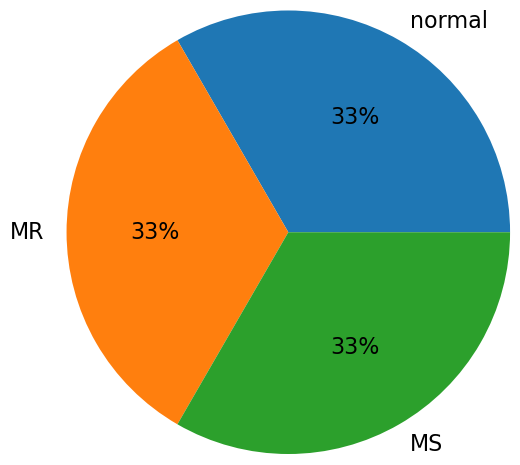

In [74]:
# plot pie graph of 3labels normal, MR and MS
x = np.array([len(os.listdir(normal_data)),
              len(os.listdir(mr_data)),
              len(os.listdir(ms_data))])
labels = ['normal', 'MR', 'MS']
y=plt.pie(x, labels = labels, autopct = '%.0f%%', radius= 1.5, textprops={'fontsize': 16})
plt.show(y)

In [75]:
# Listen to rondom audio from specific class
def random_sound (audio_class):
    random_sound = np.random.randint(0,len(os.listdir(audio_class)))  # generates a random between 0 and the number of items in the directory 
    sound = os.listdir(audio_class)[random_sound]    # The random index generated in the previous step to select a sound file from the directory
    sound = audio_class+sound                        # appends the directory path
    sound,sample_rate = librosa.load(sound)          # To load the audio data from the specified sound file.
    return ipd.Audio(sound,rate=sample_rate),sound   # creates an IPython display of the audio

In [76]:
# show waveform of audio from dataset 
# X axis, represents time.
# Y-axis measures displacement of air molecules.
# This is where amplitude comes in. It measures how much a molecule is displaced from its resting position.  
def show_audio_waveform(audio_sample):
    plt.figure(figsize=(20,5))  # canvas on which the waveform visualization
    librosa.display.waveshow(audio_sample, sr = 22050) # display the waveform of the audio_sample
#     plt.title("Sound")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.show()

In [77]:
# show spectrum of audio from dataset 
def show_audio_spectrum(audio_sample):
    sample_rate = 22050
    fft_normal = np.fft.fft(audio_sample)  #  performs the Fast Fourier Transform (FFT) on the audio_sample array
    magnitude_normal = np.abs(fft_normal)  #  calculates the magnitude of the FFT result
    freq_normal = np.linspace(0,sample_rate, len(magnitude_normal)) # creates an array of frequency values
    half_freq = freq_normal[:int(len(freq_normal)/2)] # extract the first half of the frequency and magnitude arrays
    half_magnitude = magnitude_normal[:int(len(freq_normal)/2)]
    
    # plot
    plt.figure(figsize=(12,8))  # plotting with a specified size.
    plt.plot(half_freq,half_magnitude) # plots the frequency spectrum using the extracted half frequency and magnitude arrays.
    plt.title("Spectrum")
    plt.xlabel("Frequency")
    plt.ylabel("Magnitude")
    plt.show()

In [78]:
# show spectrogram of audio from dataset 
# the output is an image that represents a sound. 
# X-axis is for time, y-axis is for frequency and the color is for intensity
def show_spectrogram (audio_sample):    
    # STFT -> spectrogram
    hop_length = 512 # in num. of samples
    n_fft = 2048 # window in num. of samples
    sample_rate = 22050  # frequency

    # calculate duration hop length and window in seconds
    hop_length_duration = float(hop_length)/sample_rate  # calculate the corresponding durations
    n_fft_duration = float(n_fft)/sample_rate            # parameters in seconds based on the given sample rate

    print("STFT hop length duration is: {}s".format(hop_length_duration))
    print("STFT window duration is: {}s".format(n_fft_duration))

    # perform stft
    stft_normal = librosa.stft(audio_sample, n_fft=n_fft, hop_length=hop_length) # compute the Short-Time Fourier Transform

    # calculate abs values on complex numbers to get magnitude
    spectrogram = np.abs(stft_normal)
    log_spectrogram = librosa.amplitude_to_db(spectrogram)

    # display spectrogram
    plt.figure(figsize=(15,10))
    librosa.display.specshow(log_spectrogram, sr=sample_rate, hop_length=hop_length)
    plt.xlabel("Time")
    plt.ylabel("Frequency")
    plt.colorbar()
    #plt.set_cmap("YlOrBr")
    plt.title("Spectrogram")

In [79]:
def show_mel_spectrogram(audio_sample, sample_rate=22050):
    # Calculate duration in seconds
    duration = len(audio_sample) / sample_rate

    print("Audio duration is: {}s".format(duration))

    # Compute the mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(
        y=audio_sample,
        sr=sample_rate,
        n_fft=2048,
        hop_length=512,
        n_mels=128  # Adjust the number of mel bands as needed
    )

    # Convert to decibels
    log_mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)

    # Display mel spectrogram
    plt.figure(figsize=(15, 10))
    librosa.display.specshow(log_mel_spectrogram, sr=sample_rate, hop_length=512, x_axis='time', y_axis='mel')
    plt.xlabel("Time")
    plt.ylabel("Mel Frequency")
    plt.colorbar(format='%+2.0f dB')
    plt.title("Mel Spectrogram")

# Replace 'audio_sample' with your actual audio data
# audio_sample, sample_rate = librosa.load('your_audio_file.mp3', sr=None)  # Use sr=None to preserve the original sample rate
# show_mel_spectrogram(audio_sample, sample_rate)

In [80]:
# MFCCs
# extract 52 MFCCs
def show_mfcc_features(audio_sample):
    # Parameters
    hop_length = 512
    n_fft = 2048
    sample_rate = 22050

    # Compute MFCCs
    MFCCs = librosa.feature.mfcc(y=audio_sample, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)

    # Display MFCCs
    plt.figure(figsize=(15, 7))
    librosa.display.specshow(MFCCs, x_axis='time')
    plt.colorbar()
    plt.title('MFCCs')
    plt.xlabel('Time')
    plt.ylabel('MFCC Coefficients')
    plt.show()

In [81]:
from scipy.fft import fft
def find_dominant_frequency(signal, sampling_frequency):
    """
    Finds the dominant frequency in a signal using Fourier Transform.
    
    Args:
        signal (list or numpy array): The input signal.
        sampling_frequency (float): Sampling frequency of the signal.
        
    Returns:
        float: The dominant frequency in Hertz (Hz).
    """
    signal_spectrum = fft(signal)
    frequency_domain = np.fft.fftfreq(len(signal), d=1/sampling_frequency)
    
    dominant_frequency_index = np.argmax(np.abs(signal_spectrum))
    dominant_frequency = frequency_domain[dominant_frequency_index]
    
    return dominant_frequency

In [82]:
from scipy.stats import entropy

def calculate_shannon_entropy(heart_sound_data, num_bins=10):
    # Calculate the probability distribution of the amplitude values
    hist, _ = np.histogram(heart_sound_data, bins=num_bins, density=True)
    prob_dist = hist / np.sum(hist)

    # Calculate Shannon entropy using the probability distribution
    shannon_entropy = entropy(prob_dist, base=2)  # Using base 2 for bits
    return shannon_entropy

In [83]:
# Amplitude
def calculate_amplitude(waveform):
    """
    Calculate the amplitude of a waveform.
    
    Parameters:
        waveform (array-like): The input waveform.
        
    Returns:
        float: The calculated amplitude.
    """
    amplitude = np.max(np.abs(waveform))
    return amplitude

In [84]:
normal_audio, normal_sample  = random_sound(normal_data)
normal_audio

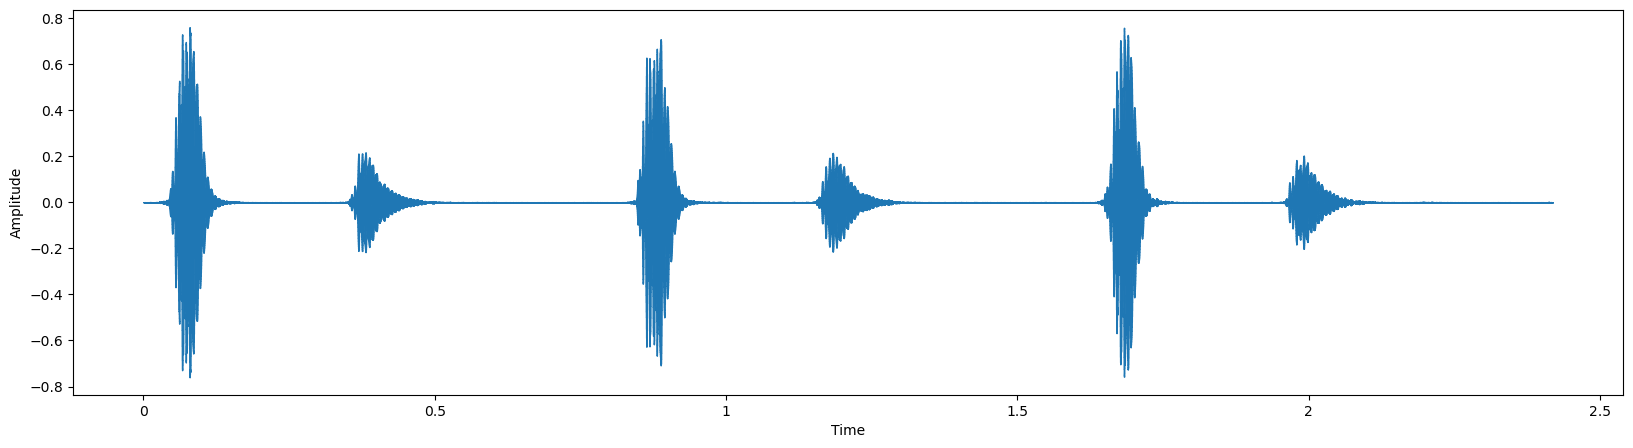

In [85]:
show_audio_waveform(normal_sample)

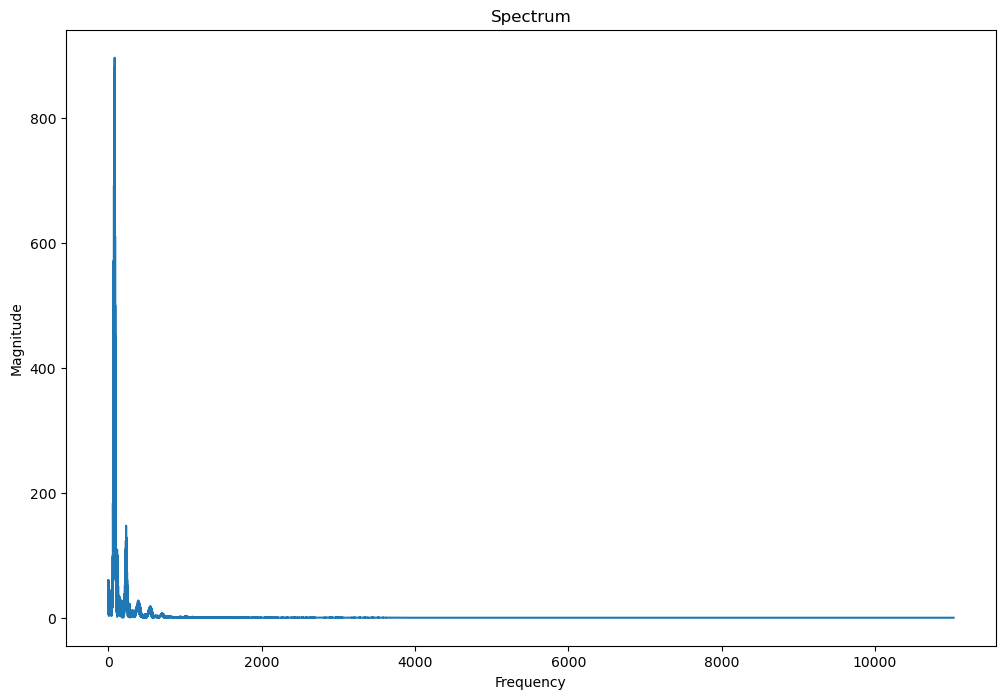

In [86]:
show_audio_spectrum(normal_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


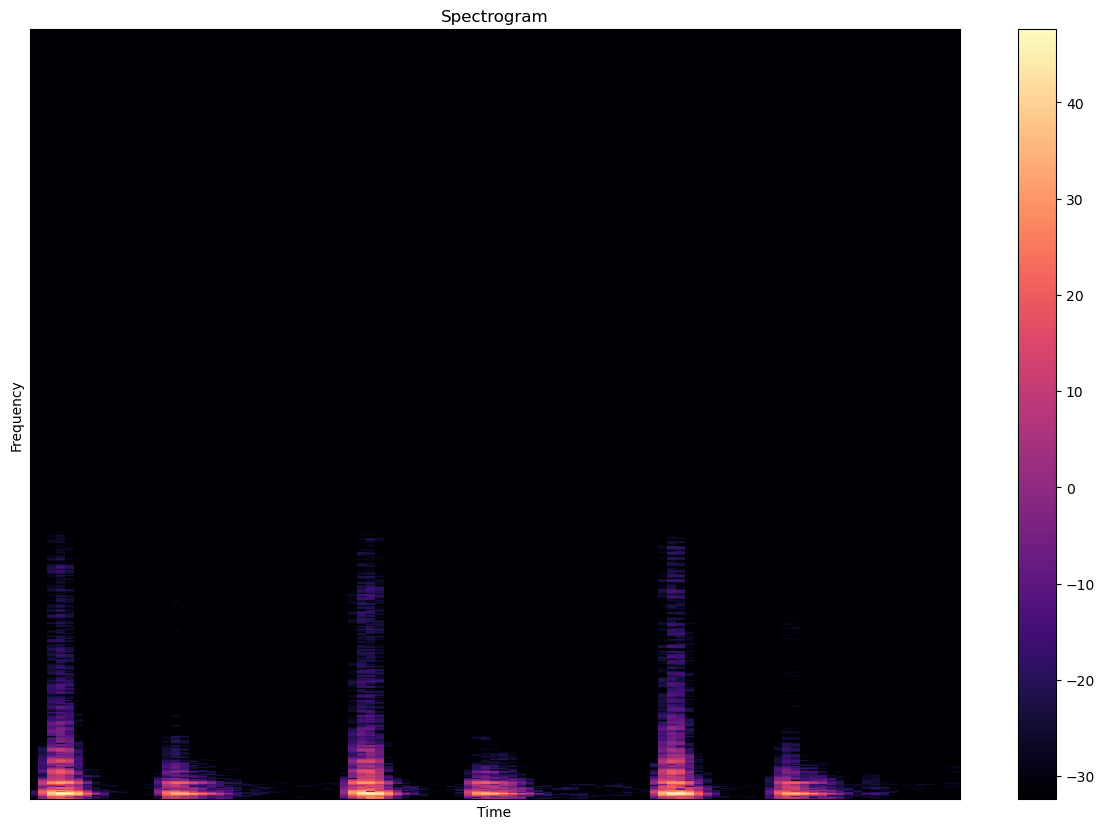

In [87]:
show_spectrogram(normal_sample)

Audio duration is: 2.4189115646258506s


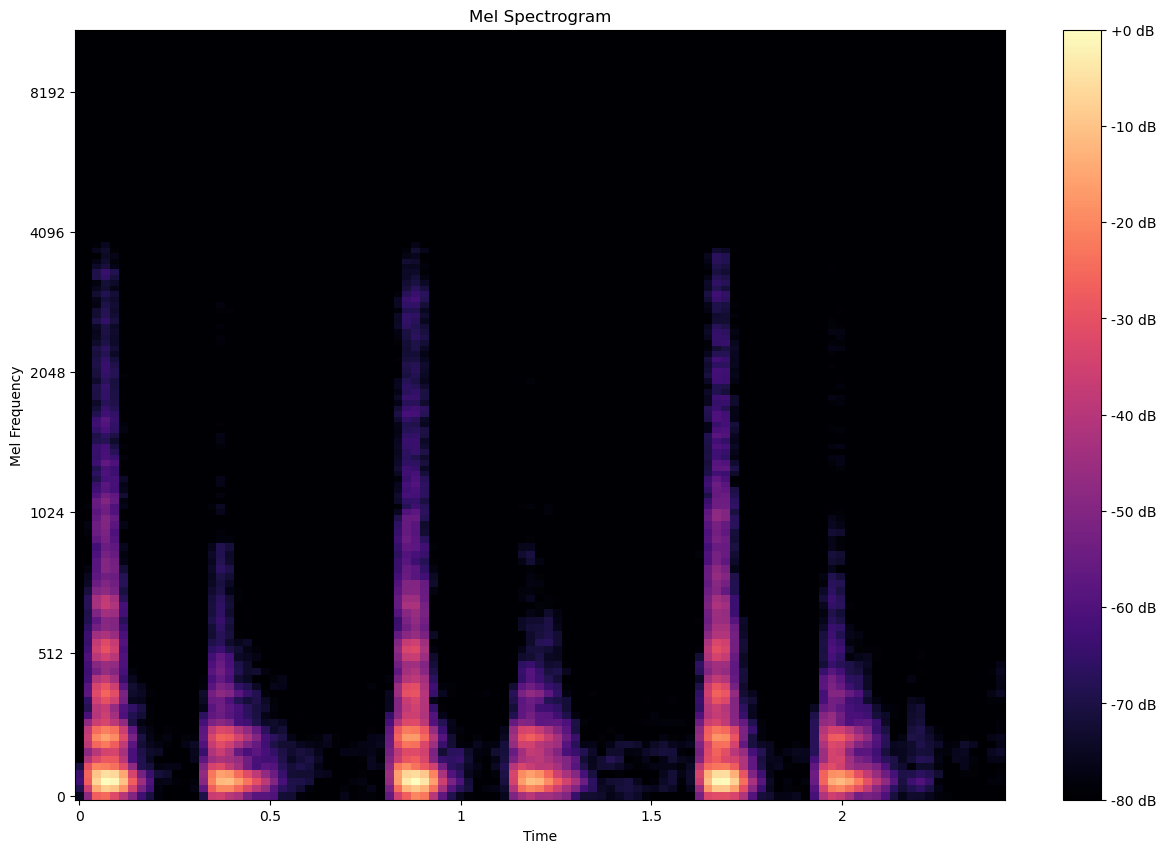

In [88]:
show_mel_spectrogram(normal_sample)

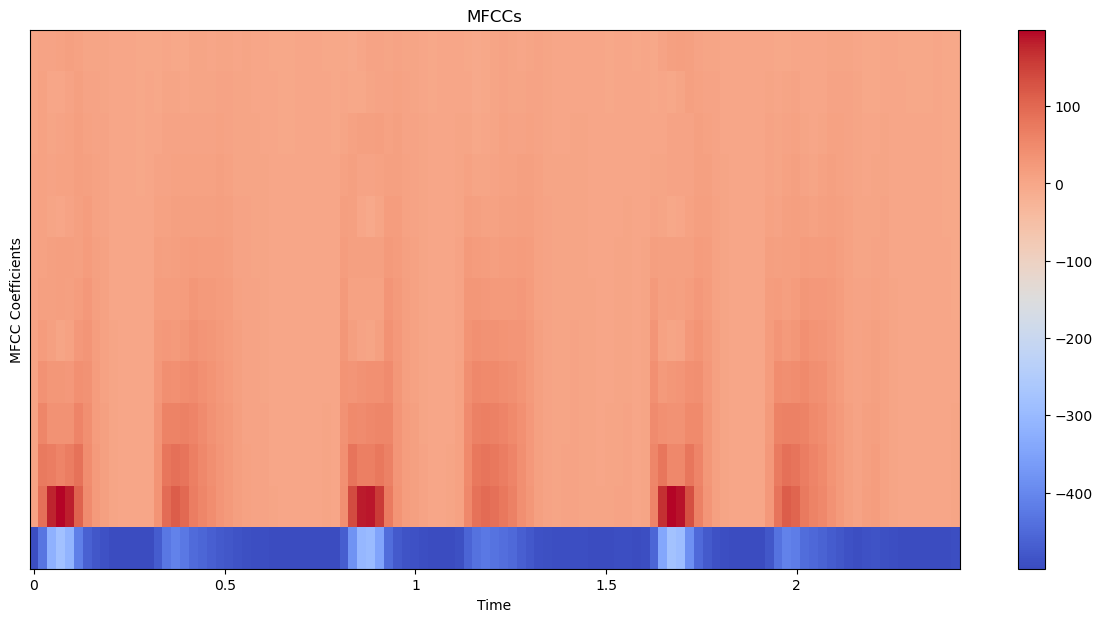

In [89]:
show_mfcc_features(normal_sample)

In [90]:
mr_audio, mr_sample  = random_sound(mr_data)
mr_audio

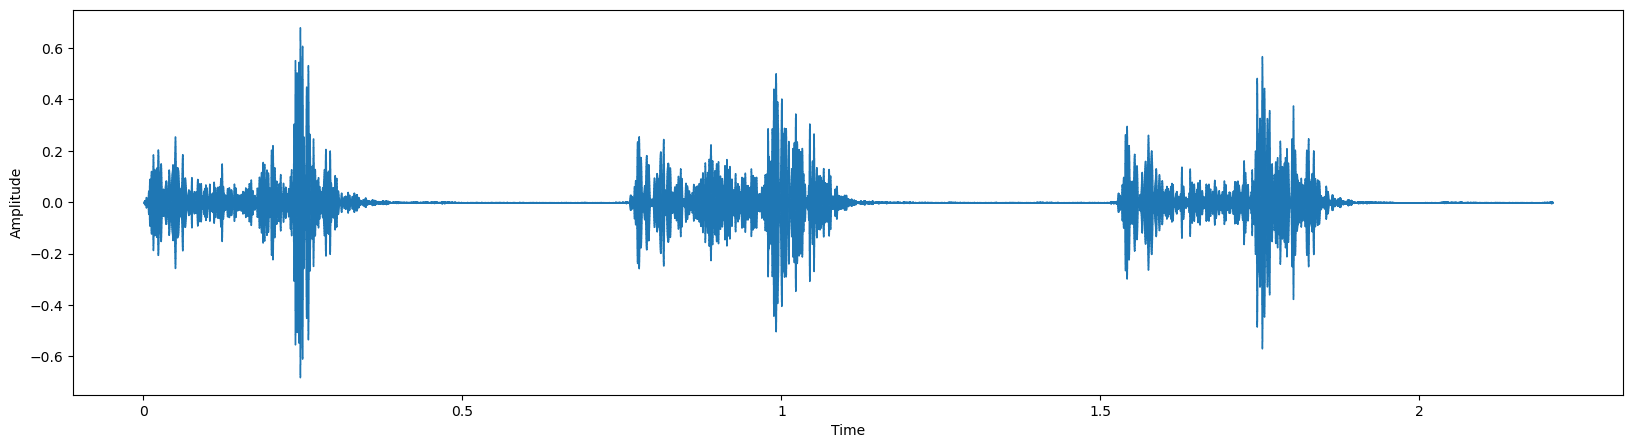

In [91]:
show_audio_waveform(mr_sample)

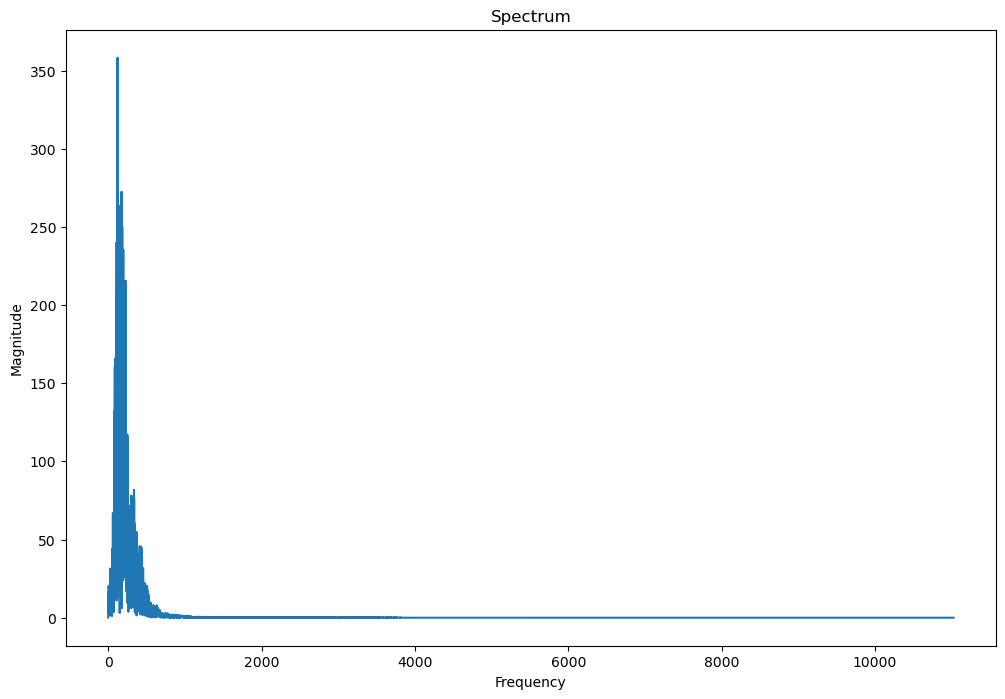

In [92]:
show_audio_spectrum(mr_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


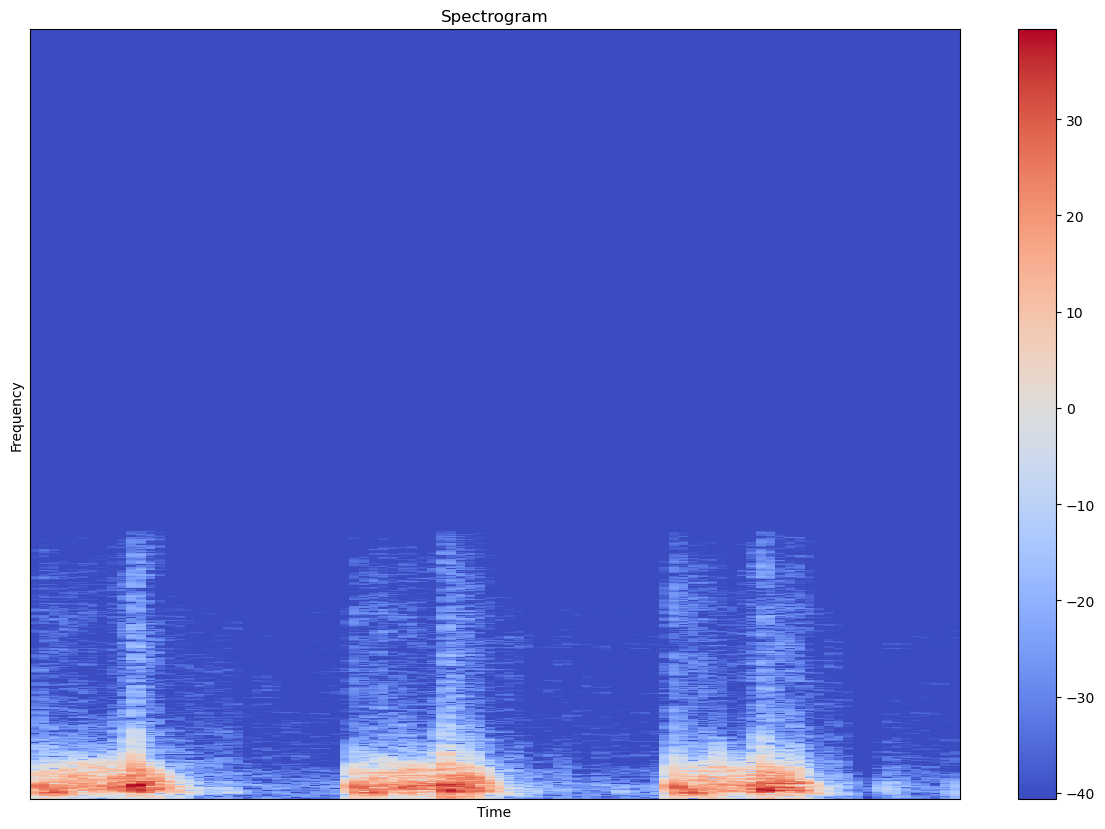

In [93]:
show_spectrogram(mr_sample)

Audio duration is: 2.2088888888888887s


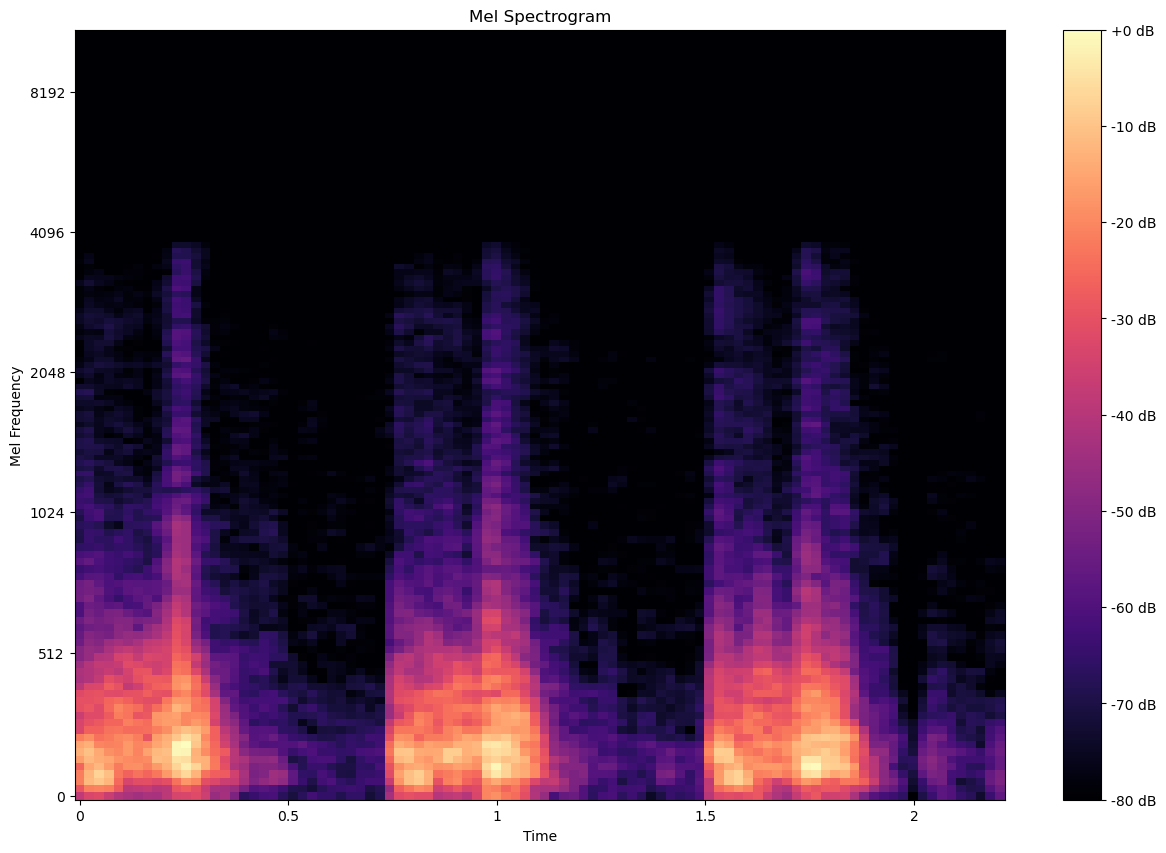

In [94]:
show_mel_spectrogram(mr_sample)

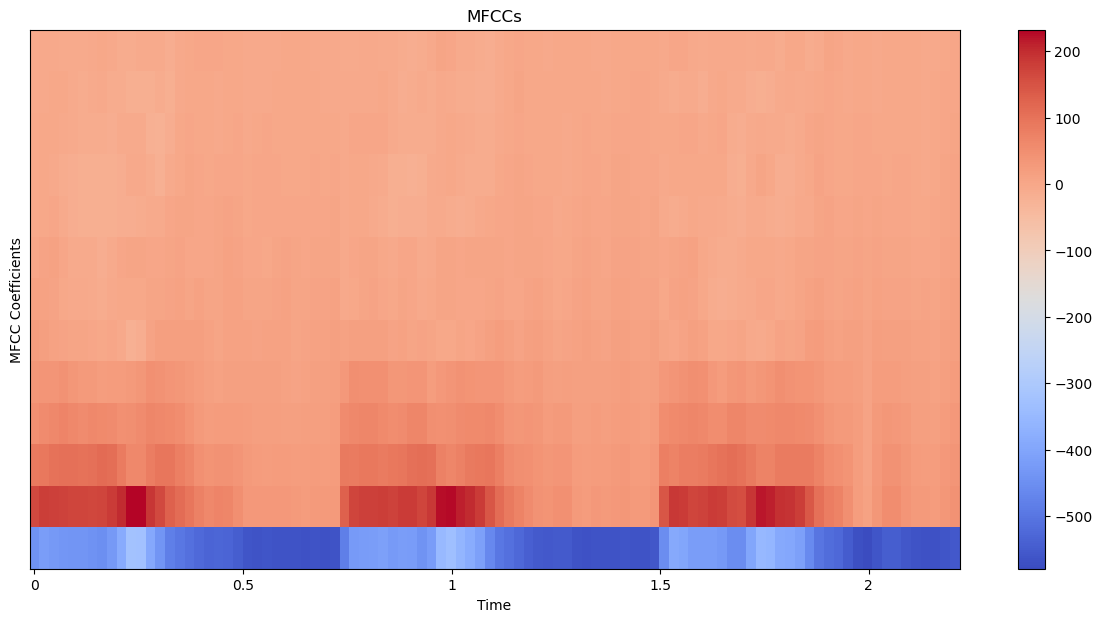

In [95]:
show_mfcc_features(mr_sample)

In [96]:
ms_audio, ms_sample  = random_sound(ms_data)
ms_audio

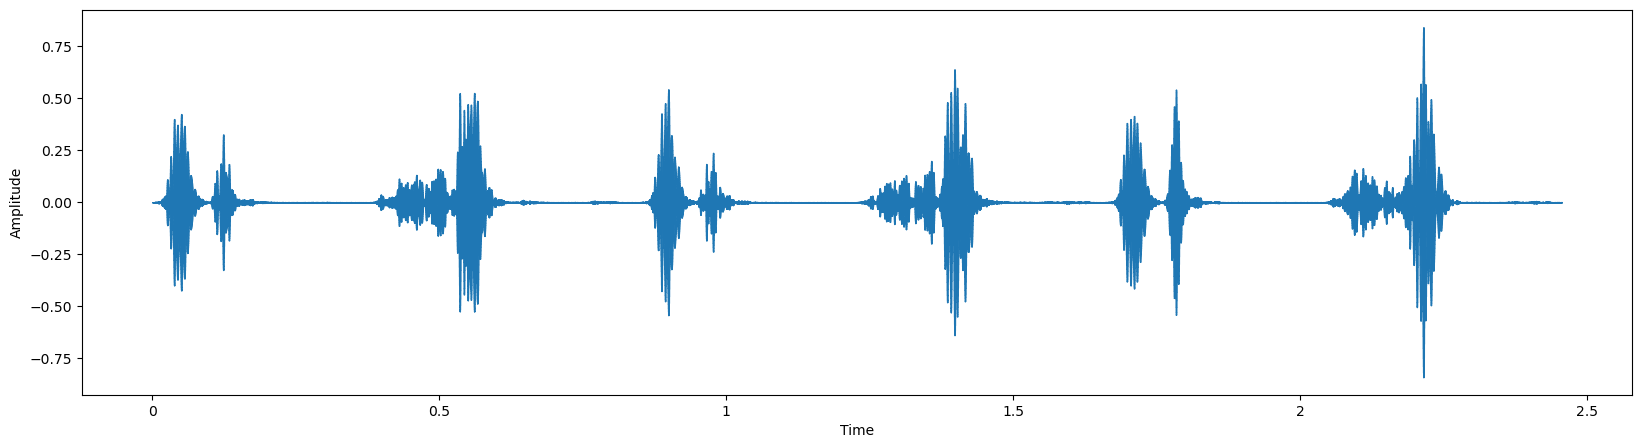

In [97]:
show_audio_waveform(ms_sample)

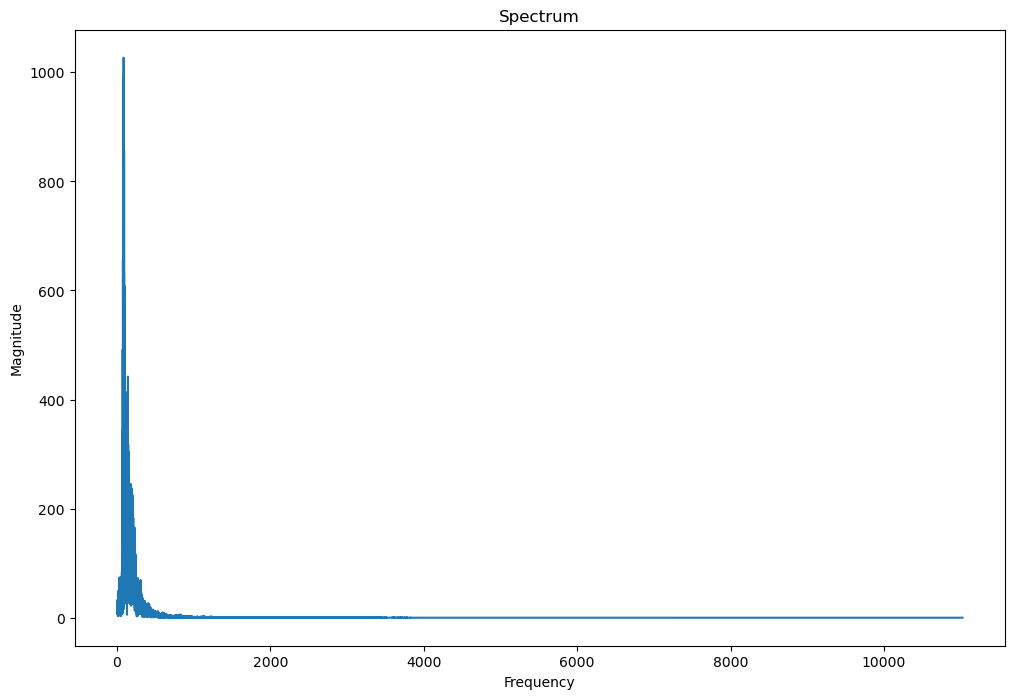

In [30]:
show_audio_spectrum(ms_sample)

STFT hop length duration is: 0.023219954648526078s
STFT window duration is: 0.09287981859410431s


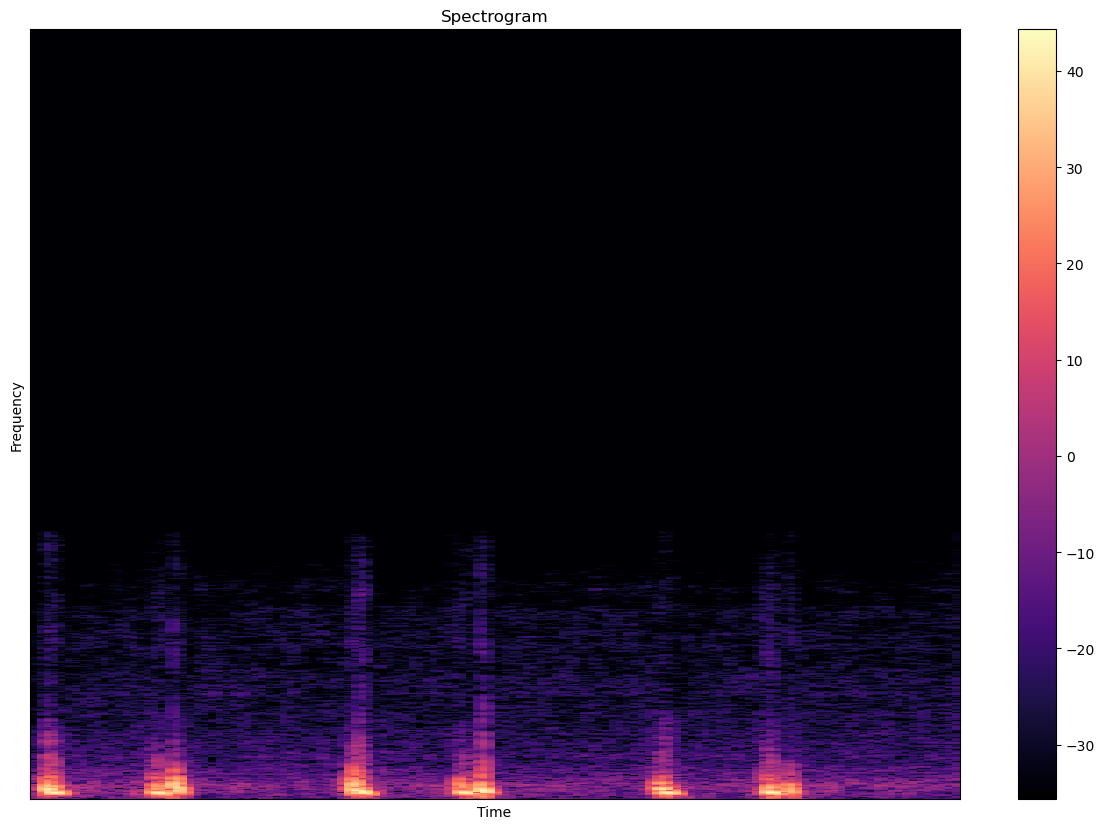

In [31]:
show_spectrogram(ms_sample)

Audio duration is: 3.00702947845805s


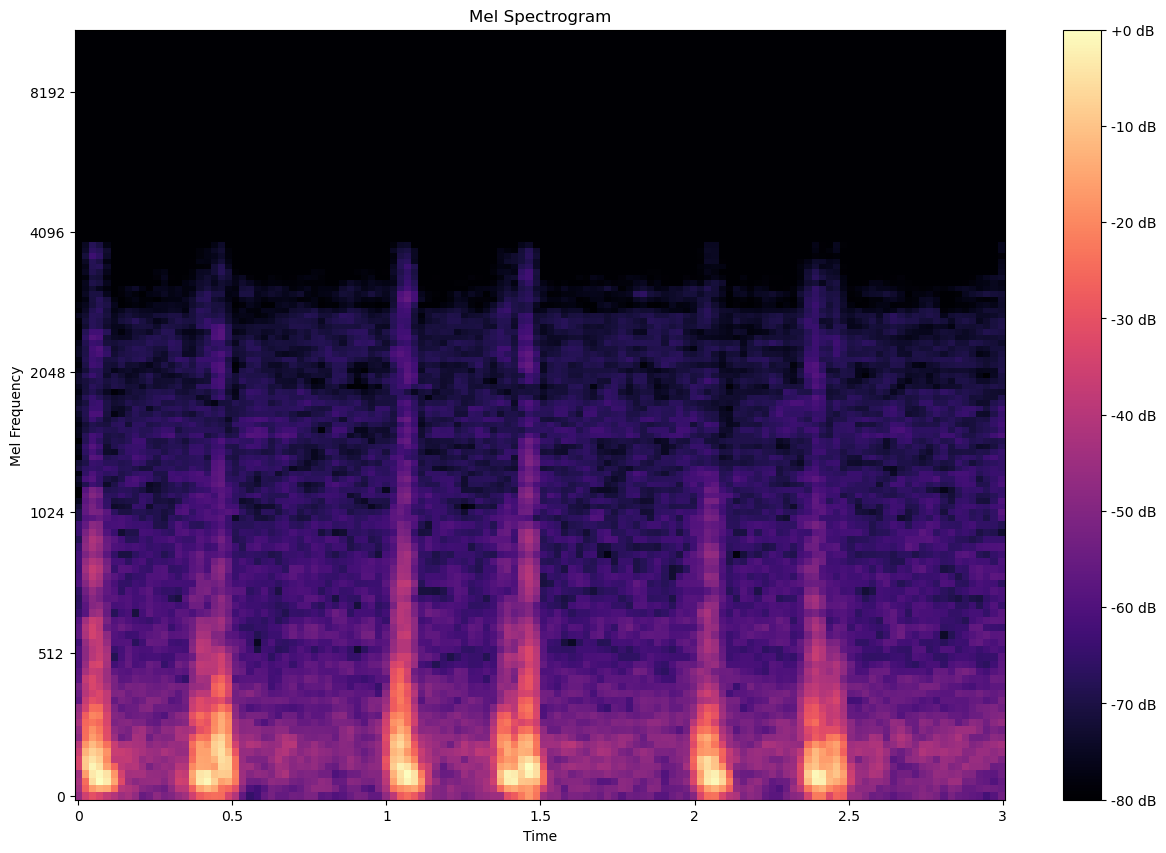

In [32]:
show_mel_spectrogram(ms_sample)

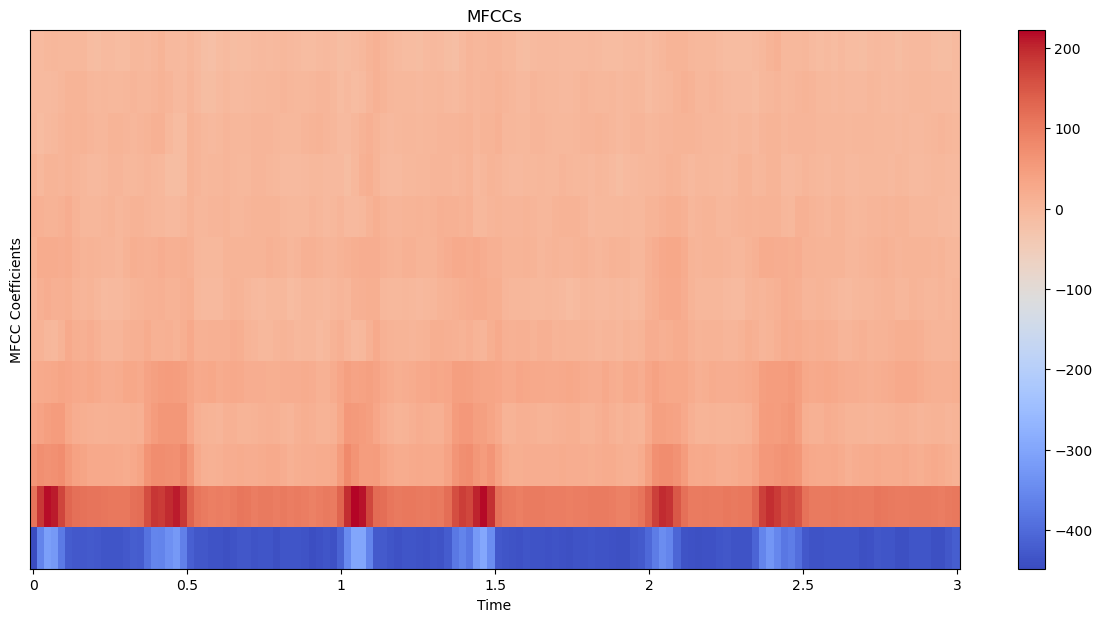

In [33]:
show_mfcc_features(ms_sample)

In [62]:
def add_noise(data,x):
    noise = np.random.randn(len(data))
    data_noise = data + x * noise
    return data_noise

def shift(data,x):
    return np.roll(data, x)

def stretch(data, rate):
    data = librosa.effects.time_stretch(data, rate)
    return data

def pitch_shift (data , rate):
    data = librosa.effects.pitch_shift(data, sr=220250, n_steps=rate)
    return data

In [63]:
def load_file_data (folder, file_names, duration=10, sr=22050):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        52 features are extracted from each audio data and used to train the model.
        
        Args: 
            dir_: Input directory to the Sound input file.
        
        Returns:
            data: list of features extracted from the sound file.
    '''
    input_length=sr*duration
    features = 52
    data = []
    for file_name in file_names:
        try:
            sound_file = folder+file_name
            X, sr = librosa.load( sound_file, sr=sr, duration=duration) 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print ("fixing audio lenght :", file_name)
                X = librosa.util.fix_length(X, input_length)  
                
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=features).T,axis=0) 
            feature = np.array(mfccs).reshape([-1,1])
            data.append(feature)
            
            stretch_data_1 = stretch (X, 0.8)
            mfccs_stretch_1 = np.mean(librosa.feature.mfcc(y=stretch_data_1, sr=sr, n_mfcc=features).T,axis=0) 
            feature_1 = np.array(mfccs_stretch_1).reshape([-1,1])
            data.append(feature_1)
            
            stretch_data_2 = stretch (X, 1.2) 
            mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=stretch_data_2, sr=sr, n_mfcc=features).T,axis=0) 
            feature_2 = np.array(mfccs_stretch_2).reshape([-1,1])
            data.append(feature_2)
            
        except Exception as e:
            print("Error encountered while parsing file: ", file_name)        
        
    return data

In [64]:
def load_file_data(folder, file_names, duration=10, sr=22050):
    '''
        Extract MFCC feature from the Sound data from the audio data. 
        Augmentation of sound data by adding Noise, streaching and shifting.
        52 features are extracted from each audio data and used to train the model.
        
        Args: 
            dir_: Input directory to the Sound input file.
        
        Returns:
            data: list of features extracted from the sound file.
    '''
    input_length = sr * duration
    features = 52
    data = []
    for file_name in file_names:
        try:
            sound_file = folder + file_name
            X, sr = librosa.load(sound_file, sr=sr, duration=duration) 
            dur = librosa.get_duration(y=X, sr=sr)
            # pad audio file same duration
            if (round(dur) < duration):
                print("Fixing audio length:", file_name)
                X = librosa.util.fix_length(X, input_length)  
                
            # extract normalized mfcc feature from data
            mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=features).T,axis=0) 
            feature = np.array(mfccs).reshape([-1,1])
            data.append(feature)
            
            stretch_data_1 = stretch(X, 0.8)
            mfccs_stretch_1 = np.mean(librosa.feature.mfcc(y=stretch_data_1, sr=sr, n_mfcc=features).T,axis=0) 
            feature_1 = np.array(mfccs_stretch_1).reshape([-1,1])
            data.append(feature_1)
            
            stretch_data_2 = stretch(X, 1.2) 
            mfccs_stretch_2 = np.mean(librosa.feature.mfcc(y=stretch_data_2, sr=sr, n_mfcc=features).T,axis=0) 
            feature_2 = np.array(mfccs_stretch_2).reshape([-1,1])
            data.append(feature_2)
            
        except Exception as e:
             print("Error encountered while parsing file:", file_name)        
        
    return data

In [65]:
# simple encoding of categories, convert to only 3 types:
# Normal (Include extrahls and extrastole)
# Murmur
# Artifact

# Map label text to integer
CLASSES = ['MS','MR','Normal']
NB_CLASSES=len(CLASSES)

# Map integer value to text labels
label_to_int = {k:v for v,k in enumerate(CLASSES)}
print (label_to_int)
print (" ")
int_to_label = {v:k for k,v in label_to_int.items()}
print(int_to_label)

{'MS': 0, 'MR': 1, 'Normal': 2}
 
{0: 'MS', 1: 'MR', 2: 'Normal'}


In [66]:
# 22 KHz
SAMPLE_RATE = 22050
# 10 seconds
MAX_SOUND_CLIP_DURATION=10

ms_files = fnmatch.filter(os.listdir(ms_data), '*.wav')
ms_sounds = load_file_data(folder=ms_data, file_names = ms_files, duration=MAX_SOUND_CLIP_DURATION)
ms_labels = [0 for items in ms_sounds]

normal_files = fnmatch.filter(os.listdir(normal_data), '*.wav')
normal_sounds = load_file_data(folder=normal_data,file_names=normal_files, duration=MAX_SOUND_CLIP_DURATION)
normal_labels = [2 for items in normal_sounds]


mr_files = fnmatch.filter(os.listdir(mr_data), '*.wav')
mr_sounds = load_file_data(folder=mr_data,file_names=mr_files, duration=MAX_SOUND_CLIP_DURATION)
mr_labels = [1 for items in mr_sounds]



print ("Loading Done")

Fixing audio length: New_MS_007.wav
Error encountered while parsing file: New_MS_007.wav
Fixing audio length: New_MS_008.wav
Error encountered while parsing file: New_MS_008.wav
Fixing audio length: New_MS_009.wav
Error encountered while parsing file: New_MS_009.wav
Fixing audio length: New_MS_010.wav
Error encountered while parsing file: New_MS_010.wav
Fixing audio length: New_MS_011.wav
Error encountered while parsing file: New_MS_011.wav
Fixing audio length: New_MS_012.wav
Error encountered while parsing file: New_MS_012.wav
Fixing audio length: New_MS_013.wav
Error encountered while parsing file: New_MS_013.wav
Fixing audio length: New_MS_014.wav
Error encountered while parsing file: New_MS_014.wav
Fixing audio length: New_MS_015.wav
Error encountered while parsing file: New_MS_015.wav
Fixing audio length: New_MS_016.wav
Error encountered while parsing file: New_MS_016.wav
Fixing audio length: New_MS_017.wav
Error encountered while parsing file: New_MS_017.wav
Fixing audio length: 

Fixing audio length: New_N_185.wav
Error encountered while parsing file: New_N_185.wav
Fixing audio length: New_N_186.wav
Error encountered while parsing file: New_N_186.wav
Fixing audio length: New_N_187.wav
Error encountered while parsing file: New_N_187.wav
Fixing audio length: New_N_188.wav
Error encountered while parsing file: New_N_188.wav
Fixing audio length: New_N_189.wav
Error encountered while parsing file: New_N_189.wav
Fixing audio length: New_N_190.wav
Error encountered while parsing file: New_N_190.wav
Fixing audio length: New_N_191.wav
Error encountered while parsing file: New_N_191.wav
Fixing audio length: New_N_192.wav
Error encountered while parsing file: New_N_192.wav
Fixing audio length: New_N_193.wav
Error encountered while parsing file: New_N_193.wav
Fixing audio length: New_N_194.wav
Error encountered while parsing file: New_N_194.wav
Fixing audio length: New_N_199.wav
Error encountered while parsing file: New_N_199.wav
Fixing audio length: New_N_200.wav
Error en

In [68]:
# unlabel_datala files
unlabelledtest_files = fnmatch.filter(os.listdir(unlabel_data), '*.wav')
unlabelledtest_sounds = load_file_data(folder=unlabel_data,file_names=unlabelledtest_files, duration=MAX_SOUND_CLIP_DURATION)
unlabelledtest_labels = [-1 for items in unlabelledtest_sounds]


print ("Loading of unlabel data done")


Fixing audio length: unlabelledtest (1).wav
Error encountered while parsing file: unlabelledtest (1).wav
Fixing audio length: unlabelledtest (10).wav
Error encountered while parsing file: unlabelledtest (10).wav
Fixing audio length: unlabelledtest (100).wav
Error encountered while parsing file: unlabelledtest (100).wav
Fixing audio length: unlabelledtest (101).wav
Error encountered while parsing file: unlabelledtest (101).wav
Fixing audio length: unlabelledtest (102).wav
Error encountered while parsing file: unlabelledtest (102).wav
Fixing audio length: unlabelledtest (103).wav
Error encountered while parsing file: unlabelledtest (103).wav
Fixing audio length: unlabelledtest (104).wav
Error encountered while parsing file: unlabelledtest (104).wav
Fixing audio length: unlabelledtest (105).wav
Error encountered while parsing file: unlabelledtest (105).wav
Fixing audio length: unlabelledtest (106).wav
Error encountered while parsing file: unlabelledtest (106).wav
Fixing audio length: unla

In [67]:
#combine set-a and set-b 
x_data = np.concatenate((ms_sounds,normal_sounds, mr_sounds))

y_data = np.concatenate((ms_labels,normal_labels, mr_labels))

test_x = unlabelledtest_sounds
test_y = unlabelledtest_labels

print ("combined training data record: ",len(y_data), len(test_y))

combined training data record:  0 0


### Feature Extraction

#### Statistical Feature

In [40]:
# Standard Deviation
print("Standard Deviation for Dataset 1:", np.std(x_data))
print("Standard Deviation for Dataset 2:", np.std(y_data))

Standard Deviation for Dataset 1: 74.71289
Standard Deviation for Dataset 2: 0.816496580927726


In [41]:
# Kurtosis
from scipy.stats import kurtosis
print("Kurtosis for Dataset 1:", kurtosis(x_data))
print("Kurtosis for Dataset 2:", kurtosis(y_data))

Kurtosis for Dataset 1: [[ 9.07182693e-04]
 [ 4.52681780e-01]
 [ 1.22354317e+00]
 [-1.37312412e-01]
 [ 2.93946266e-01]
 [ 1.82950640e+00]
 [ 1.36988068e+00]
 [ 9.45423841e-01]
 [ 2.34982014e-01]
 [-7.39945412e-01]
 [-2.55192995e-01]
 [-3.73983145e-01]
 [-9.31979895e-01]
 [-7.17085838e-01]
 [-3.19619179e-02]
 [-5.25956154e-01]
 [-4.09099102e-01]
 [-5.27703762e-02]
 [ 1.14479065e-02]
 [-9.84636784e-01]
 [-1.03344119e+00]
 [-7.05611229e-01]
 [-9.35270548e-01]
 [-9.48562622e-01]
 [-1.26495421e+00]
 [-1.22563219e+00]
 [-1.05632091e+00]
 [-1.08061433e+00]
 [-8.25802326e-01]
 [-2.86515474e-01]
 [ 1.19725323e+00]
 [ 1.71572924e+00]
 [ 2.63240194e+00]
 [ 3.58912611e+00]
 [ 2.73536777e+00]
 [ 3.09965801e+00]
 [ 1.02296829e+00]
 [ 1.23824787e+00]
 [ 1.46469355e+00]
 [-8.55863094e-02]
 [-4.71906662e-01]
 [-6.02737188e-01]
 [-5.87428570e-01]
 [-5.40254593e-01]
 [-7.23687172e-01]
 [-8.91531229e-01]
 [-7.80297756e-01]
 [-4.56093073e-01]
 [ 2.69689560e-02]
 [ 2.77506828e-01]
 [ 4.65504169e-01]
 [ 2.15

In [42]:
# Skewness
from scipy.stats import skew
print("Skewness for Dataset 1:", skew(x_data))
print("Skewness for Dataset 2:", skew(y_data))

Skewness for Dataset 1: [[-0.621963  ]
 [ 0.69377613]
 [-0.46168646]
 [ 0.35342243]
 [ 0.48548672]
 [-0.36198363]
 [-0.22704235]
 [ 0.1113122 ]
 [-0.6100765 ]
 [-0.42750737]
 [-0.29641902]
 [-0.3599432 ]
 [-0.2576084 ]
 [-0.00573474]
 [-0.26740292]
 [-0.02230454]
 [-0.15011181]
 [-0.04256538]
 [ 0.07585879]
 [ 0.03027635]
 [-0.17088404]
 [ 0.03525444]
 [-0.1860089 ]
 [-0.2779673 ]
 [-0.04549559]
 [ 0.07341237]
 [ 0.13413414]
 [ 0.04910941]
 [ 0.0278379 ]
 [-0.22878332]
 [-0.5589063 ]
 [-0.80985796]
 [-1.141943  ]
 [-1.0609509 ]
 [-0.6508136 ]
 [-1.0480244 ]
 [-0.41116357]
 [-0.21417685]
 [-0.09185296]
 [ 0.1696271 ]
 [-0.17441247]
 [-0.5264779 ]
 [-0.67446375]
 [-0.72984004]
 [-0.5685329 ]
 [-0.47482926]
 [-0.20085862]
 [-0.24711064]
 [ 0.20177008]
 [-0.05008954]
 [-0.13734731]
 [ 0.05898658]]
Skewness for Dataset 2: 0.0


In [43]:
import numpy as np
from scipy.stats import skew, kurtosis

# Generate a sample heart sound dataset (replace this with your actual dataset)
# Assuming each audio signal is represented as a 1D numpy array
heart_sound_dataset = [
    x_data,  # Example audio signal 1
    y_data  # Example audio signal 2
    # ... Add more audio signals here
]

# Calculate statistical features for each audio signal
for idx, audio_signal in enumerate(heart_sound_dataset, start=1):
    mean = np.mean(audio_signal)
    std_dev = np.std(audio_signal)
    skewness = skew(audio_signal)
    kurt = kurtosis(audio_signal)

    print(f"Audio Signal {idx}:")
    print(f"Mean: {mean:.2f}")
    print(f"Standard Deviation: {std_dev:.2f}")
    print(f"Skewness: {skewness:}")
    print(f"Kurtosis: {kurt:}")
    print("=" * 30)

Audio Signal 1:
Mean: -9.51
Standard Deviation: 74.71
Skewness: [[-0.621963  ]
 [ 0.69377613]
 [-0.46168646]
 [ 0.35342243]
 [ 0.48548672]
 [-0.36198363]
 [-0.22704235]
 [ 0.1113122 ]
 [-0.6100765 ]
 [-0.42750737]
 [-0.29641902]
 [-0.3599432 ]
 [-0.2576084 ]
 [-0.00573474]
 [-0.26740292]
 [-0.02230454]
 [-0.15011181]
 [-0.04256538]
 [ 0.07585879]
 [ 0.03027635]
 [-0.17088404]
 [ 0.03525444]
 [-0.1860089 ]
 [-0.2779673 ]
 [-0.04549559]
 [ 0.07341237]
 [ 0.13413414]
 [ 0.04910941]
 [ 0.0278379 ]
 [-0.22878332]
 [-0.5589063 ]
 [-0.80985796]
 [-1.141943  ]
 [-1.0609509 ]
 [-0.6508136 ]
 [-1.0480244 ]
 [-0.41116357]
 [-0.21417685]
 [-0.09185296]
 [ 0.1696271 ]
 [-0.17441247]
 [-0.5264779 ]
 [-0.67446375]
 [-0.72984004]
 [-0.5685329 ]
 [-0.47482926]
 [-0.20085862]
 [-0.24711064]
 [ 0.20177008]
 [-0.05008954]
 [-0.13734731]
 [ 0.05898658]]
Kurtosis: [[ 9.07182693e-04]
 [ 4.52681780e-01]
 [ 1.22354317e+00]
 [-1.37312412e-01]
 [ 2.93946266e-01]
 [ 1.82950640e+00]
 [ 1.36988068e+00]
 [ 9.4542384

#### Signal feature

Amplitude Normal: 0.83751994


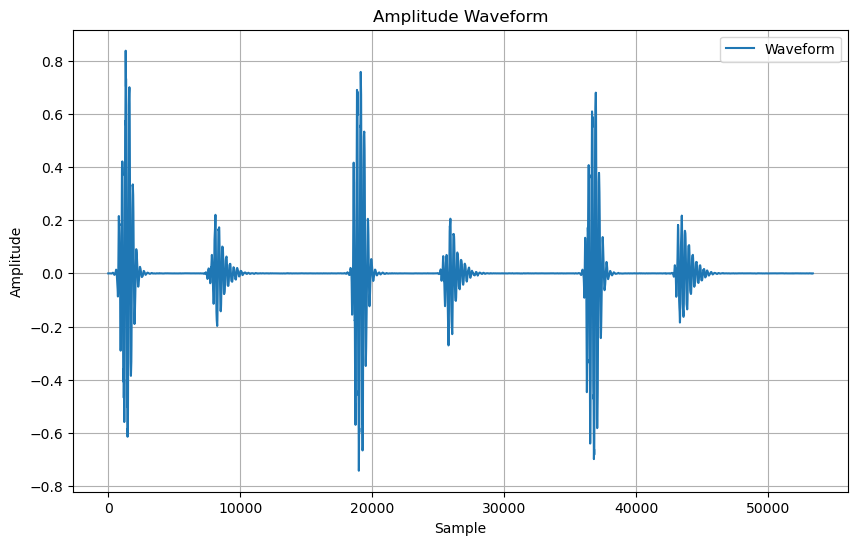

In [44]:
# Amplitude normal_sample
print("Amplitude Normal:", calculate_amplitude(normal_sample))
# Plot the waveform
plt.figure(figsize=(10, 6))
plt.plot(normal_sample, label="Waveform")
plt.title("Amplitude Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

Amplitude ms: 0.9145605


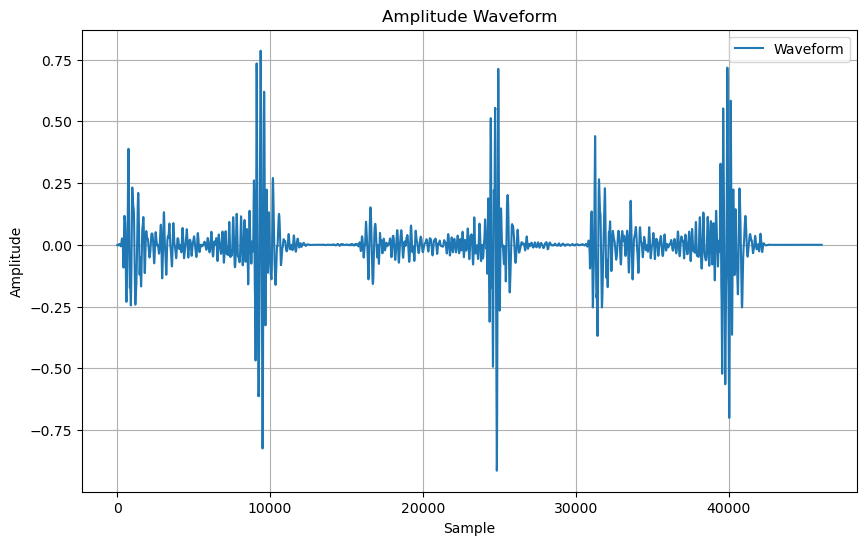

In [45]:
#Amplitude ms_sample
print("Amplitude ms:", calculate_amplitude(ms_sample))
# Plot the waveform
plt.figure(figsize=(10, 6))
plt.plot(ms_sample, label="Waveform")
plt.title("Amplitude Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

Amplitude mr: 0.55207676


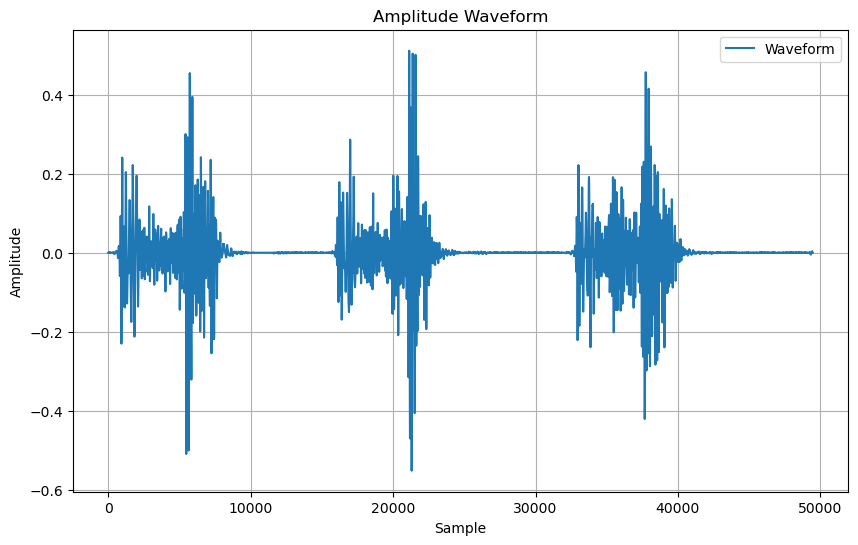

In [46]:
# Amplitude mr_sample
print("Amplitude mr:", calculate_amplitude(mr_sample))
# Plot the waveform
plt.figure(figsize=(10, 6))
plt.plot(mr_sample, label="Waveform")
plt.title("Amplitude Waveform")
plt.xlabel("Sample")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

In [47]:
#dominant frequency
fs = 22050  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector
f1 = 50  # Dominant frequency
f2 = calculate_amplitude(normal_sample)  # Additional frequency
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t) + 0.2 * np.random.randn(len(t))

dominant_freq = find_dominant_frequency(signal, fs)
print("Dominant Frequency:", dominant_freq, "Hz")

Dominant Frequency: 50.0 Hz


In [48]:
#dominant frequency
fs = 22050  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector
f1 = 50  # Dominant frequency
f2 = calculate_amplitude(mr_sample)  # Additional frequency
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t) + 0.2 * np.random.randn(len(t))

dominant_freq = find_dominant_frequency(signal, fs)
print("Dominant Frequency:", dominant_freq, "Hz")

Dominant Frequency: 50.0 Hz


In [49]:
#dominant frequency
fs = 22050  # Sampling frequency
t = np.arange(0, 1, 1/fs)  # Time vector
f1 = 50  # Dominant frequency
f2 = calculate_amplitude(ms_sample)  # Additional frequency
signal = np.sin(2 * np.pi * f1 * t) + 0.5 * np.sin(2 * np.pi * f2 * t) + 0.2 * np.random.randn(len(t))

dominant_freq = find_dominant_frequency(signal, fs)
print("Dominant Frequency:", dominant_freq, "Hz")

Dominant Frequency: 50.0 Hz


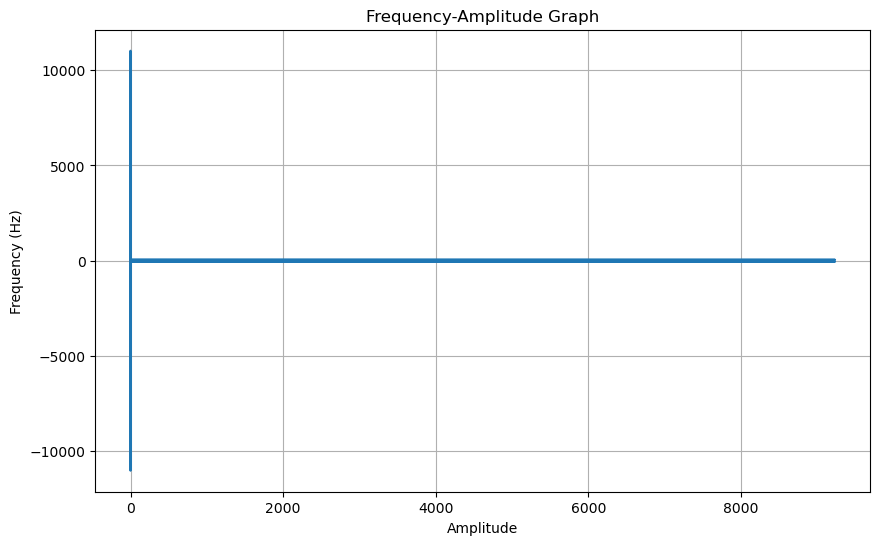

In [50]:
# plot amplitude ànd frequency with normal sound
# Generate some sample data
sample_rate = 22050  # Sampling rate in Hz
time = np.arange(0, 1, 1/sample_rate)  # Time values from 0 to 1 second
frequency = 50  # Frequency of the signal in Hz
amplitude = calculate_amplitude(normal_sample)  # Amplitude of the signal

# Create a sine wave signal
signal = amplitude * np.sin(2 * np.pi * frequency * time)

# Perform Fourier Transform
freq_domain = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(freq_domain), d=1/sample_rate)

# Plot the amplitude-frequency graph
plt.figure(figsize=(10, 6))
plt.plot(np.abs(freq_domain), frequencies)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Amplitude')
plt.title('Frequency-Amplitude Graph')
plt.grid()
plt.show()

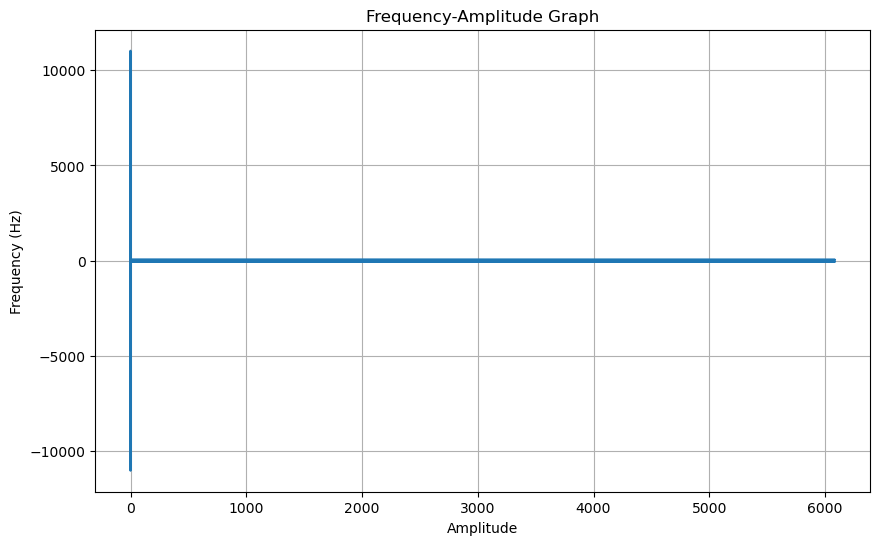

In [51]:
# plot amplitude and frequency with mr-sound
# Generate some sample data
sample_rate = 22050  # Sampling rate in Hz
time = np.arange(0, 1, 1/sample_rate)  # Time values from 0 to 1 second
frequency = 50  # Frequency of the signal in Hz
amplitude = calculate_amplitude(mr_sample)  # Amplitude of the signal

# Create a sine wave signal
signal = amplitude * np.sin(2 * np.pi * frequency * time)

# Perform Fourier Transform
freq_domain = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(freq_domain), d=1/sample_rate)

# Plot the amplitude-frequency graph
plt.figure(figsize=(10, 6))
plt.plot(np.abs(freq_domain), frequencies)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Amplitude')
plt.title('Frequency-Amplitude Graph')
plt.grid()
plt.show()

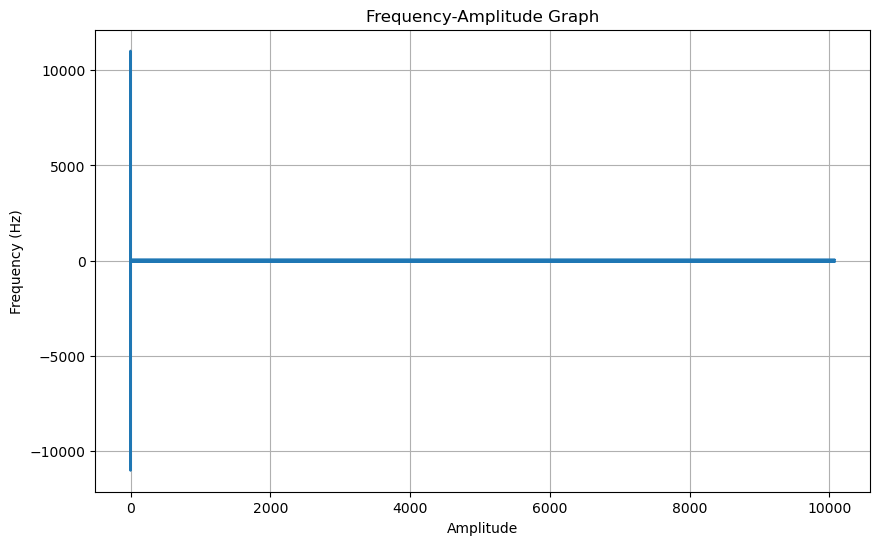

In [52]:
# plot amplitude and frequency with mr-sound
# Generate some sample data
sample_rate = 22050  # Sampling rate in Hz
time = np.arange(0, 1, 1/sample_rate)  # Time values from 0 to 1 second
frequency = 50  # Frequency of the signal in Hz
amplitude = calculate_amplitude(ms_sample)  # Amplitude of the signal

# Create a sine wave signal
signal = amplitude * np.sin(2 * np.pi * frequency * time)

# Perform Fourier Transform
freq_domain = np.fft.fft(signal)
frequencies = np.fft.fftfreq(len(freq_domain), d=1/sample_rate)

# Plot the amplitude-frequency graph
plt.figure(figsize=(10, 6))
plt.plot(np.abs(freq_domain), frequencies)
plt.ylabel('Frequency (Hz)')
plt.xlabel('Amplitude')
plt.title('Frequency-Amplitude Graph')
plt.grid()
plt.show()

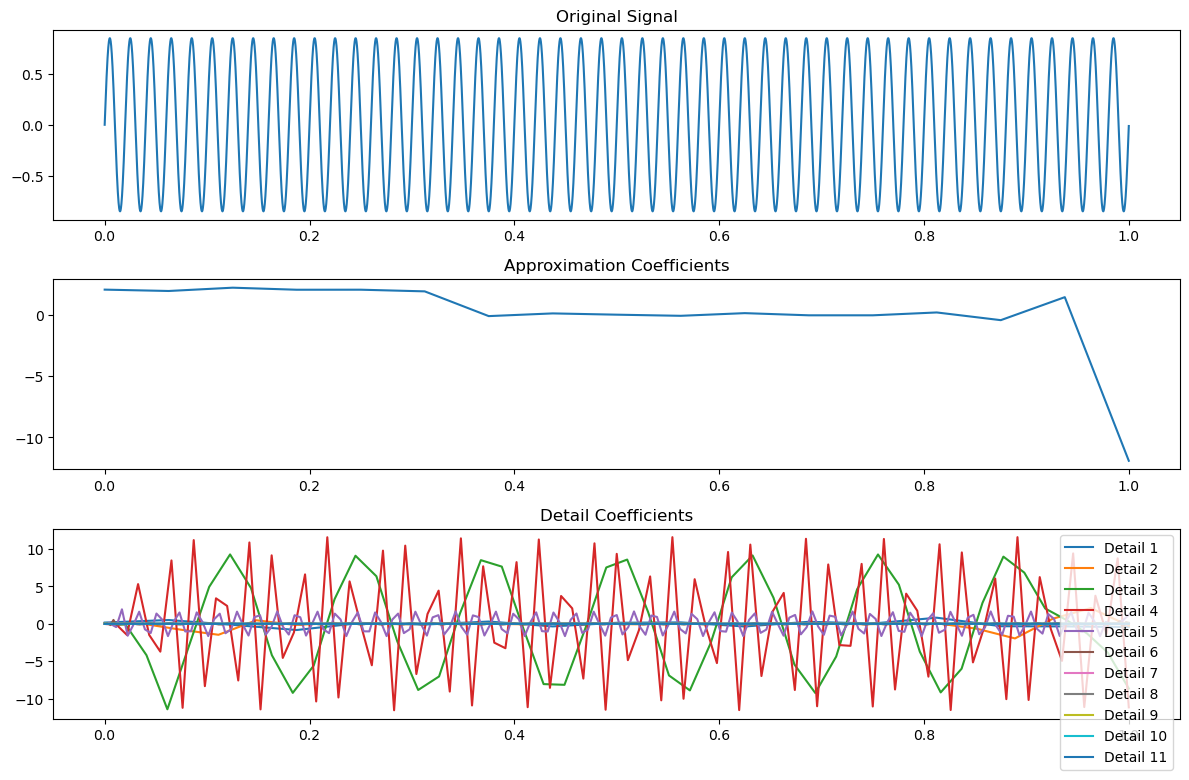

In [53]:
# wavelet feature
# normal sound
import pywt

# Generate some sample data
sample_rate = 22050  # Sampling rate in Hz
time = np.arange(0, 1, 1/sample_rate)  # Time values from 0 to 1 second
frequency = 50  # Frequency of the signal in Hz
amplitude = 0.84553736  # Amplitude of the signal

# Create a sine wave signal
signal = amplitude * np.sin(2 * np.pi * frequency * time)

# Compute the wavelet transform using 'db4' wavelet
wavelet = 'db4'
coeffs = pywt.wavedec(signal, wavelet)

# Plot the original signal
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')

# Plot the approximation coefficients
plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, 1, len(coeffs[0])), coeffs[0])
plt.title('Approximation Coefficients')

# Plot the detailed coefficients
plt.subplot(3, 1, 3)
for detail_level in range(1, len(coeffs)):
    plt.plot(np.linspace(0, 1, len(coeffs[detail_level])), coeffs[detail_level], label=f'Detail {detail_level}')
plt.title('Detail Coefficients')
plt.legend()

plt.tight_layout()
plt.show()

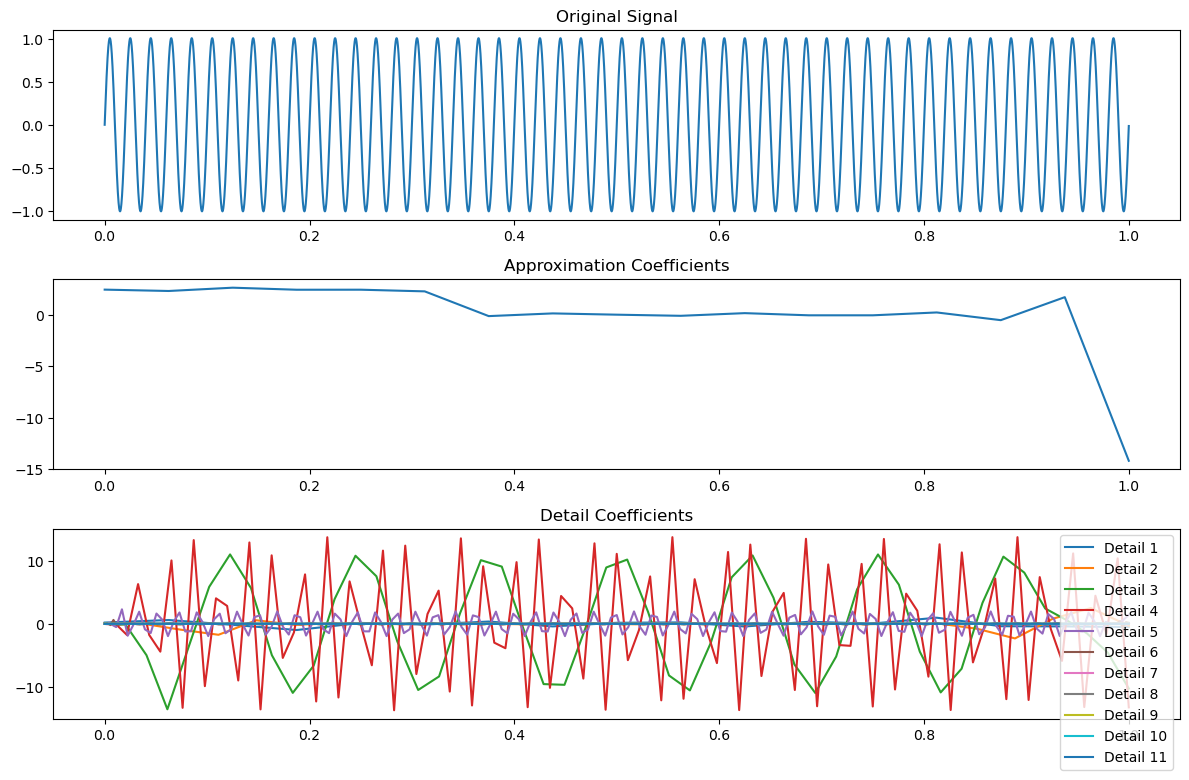

In [54]:
# wavelet feature
# ms sound
import pywt

# Generate some sample data
sample_rate = 22050  # Sampling rate in Hz
time = np.arange(0, 1, 1/sample_rate)  # Time values from 0 to 1 second
frequency = 50  # Frequency of the signal in Hz
amplitude = 1.0072287  # Amplitude of the signal

# Create a sine wave signal
signal = amplitude * np.sin(2 * np.pi * frequency * time)

# Compute the wavelet transform using 'db4' wavelet
wavelet = 'db4'
coeffs = pywt.wavedec(signal, wavelet)

# Plot the original signal
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')

# Plot the approximation coefficients
plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, 1, len(coeffs[0])), coeffs[0])
plt.title('Approximation Coefficients')

# Plot the detailed coefficients
plt.subplot(3, 1, 3)
for detail_level in range(1, len(coeffs)):
    plt.plot(np.linspace(0, 1, len(coeffs[detail_level])), coeffs[detail_level], label=f'Detail {detail_level}')
plt.title('Detail Coefficients')
plt.legend()

plt.tight_layout()
plt.show()

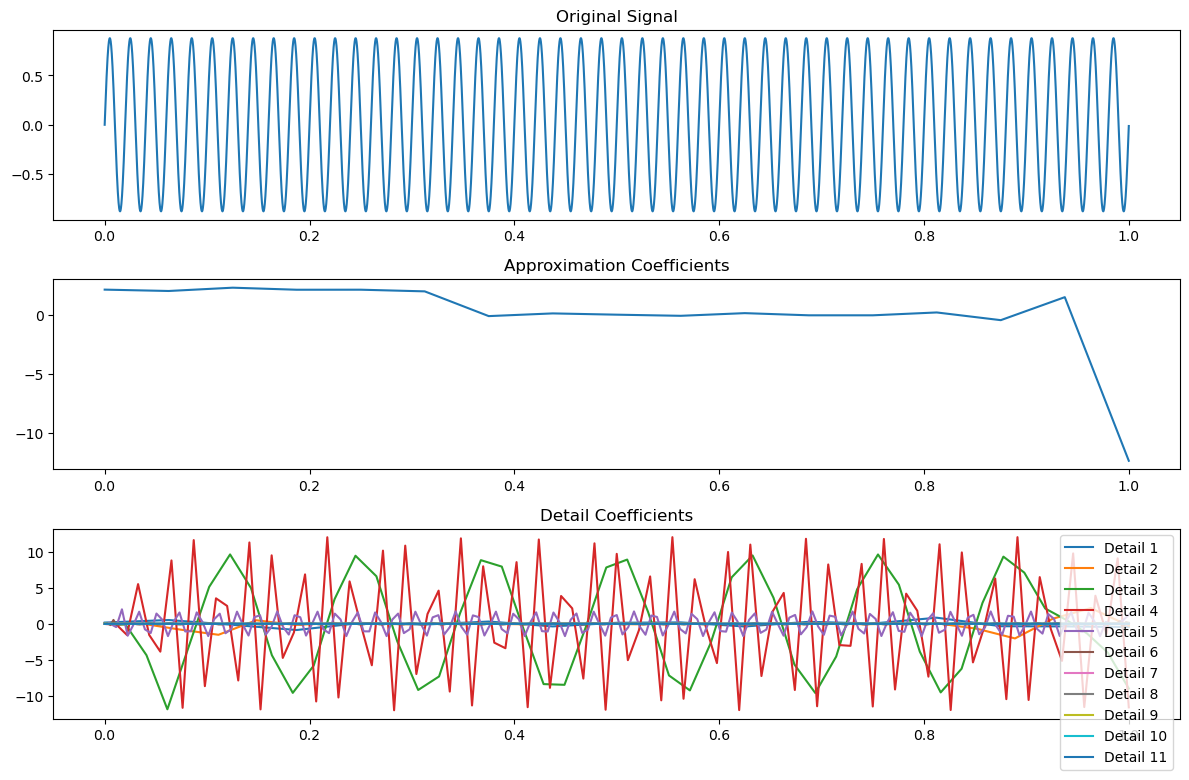

In [55]:
# wavelet feature
# mr sound
import pywt

# Generate some sample data
sample_rate = 22050  # Sampling rate in Hz
time = np.arange(0, 1, 1/sample_rate)  # Time values from 0 to 1 second
frequency = 50  # Frequency of the signal in Hz
amplitude = 0.8762585  # Amplitude of the signal

# Create a sine wave signal
signal = amplitude * np.sin(2 * np.pi * frequency * time)

# Compute the wavelet transform using 'db4' wavelet
wavelet = 'db4'
coeffs = pywt.wavedec(signal, wavelet)

# Plot the original signal
plt.figure(figsize=(12, 8))
plt.subplot(3, 1, 1)
plt.plot(time, signal)
plt.title('Original Signal')

# Plot the approximation coefficients
plt.subplot(3, 1, 2)
plt.plot(np.linspace(0, 1, len(coeffs[0])), coeffs[0])
plt.title('Approximation Coefficients')

# Plot the detailed coefficients
plt.subplot(3, 1, 3)
for detail_level in range(1, len(coeffs)):
    plt.plot(np.linspace(0, 1, len(coeffs[detail_level])), coeffs[detail_level], label=f'Detail {detail_level}')
plt.title('Detail Coefficients')
plt.legend()

plt.tight_layout()
plt.show()

In [56]:
# Information theory
# Shannon Entropy

# Generate a hypothetical heart sound dataset (amplitude values)
heart_sound_data = np.random.random(100)  # Replace this with your actual data

shannon_entropy = calculate_shannon_entropy(heart_sound_data)
print("Shannon Entropy:", shannon_entropy)

Shannon Entropy: 3.169023189736231


In [58]:
# shuffle - whether or not to shuffle the data before splitting. If shuffle=False then stratify must be None.

# split data into Train, Validation and Test
x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, train_size=0.85, random_state=42, shuffle=True)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.176, random_state=42, shuffle=True)

# One-Hot encoding for classes
y_train = np.array(tf.keras.utils.to_categorical(y_train, len(CLASSES)))
y_test = np.array(tf.keras.utils.to_categorical(y_test, len(CLASSES)))
y_val = np.array(tf.keras.utils.to_categorical(y_val, len(CLASSES)))
test_y=np.array(tf.keras.utils.to_categorical(test_y, len(CLASSES)))

In [59]:
# Print shapes for debugging
print("Shapes:")
print("x_train:", x_train.shape)
print("y_train:", y_train.shape)
print("x_val:", x_val.shape)
print("y_val:", y_val.shape)
print("x_test:", x_test.shape)
print("y_test:", y_test.shape)
print("test_y:", test_y.shape)

Shapes:
x_train: (1008, 52, 1)
y_train: (1008, 3)
x_val: (216, 52, 1)
y_val: (216, 3)
x_test: (216, 52, 1)
y_test: (216, 3)
test_y: (360, 3)


In [60]:
# class weight 
TRAIN_IMG_COUNT = 578
COUNT_0 = 40  #ms
COUNT_1 = 129 #mr
COUNT_2 = 409 #normal
weight_for_0 = TRAIN_IMG_COUNT / (3 * COUNT_0)
weight_for_1 = TRAIN_IMG_COUNT / (3 * COUNT_1)
weight_for_2 = TRAIN_IMG_COUNT / (3 * COUNT_2)
class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2}
class_weight

{0: 4.816666666666666, 1: 1.4935400516795865, 2: 0.4710676446617767}

## LSTM Model

In [61]:
x_train_lstm = x_train
x_val_lstm = x_val
x_test_lstm = x_test

y_train_lstm = y_train
y_val_lstm = y_test
y_test_lstm = y_val

In [62]:
lstm_model = Sequential()

lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))
lstm_model.add(BatchNormalization())

lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
lstm_model.add(MaxPooling1D(pool_size=2, strides = 2, padding = 'same'))

lstm_model.add(LSTM(256, return_sequences=True))
lstm_model.add(LSTM(128))
lstm_model.add(BatchNormalization())


lstm_model.add(Dense(64, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(32, activation='relu'))
lstm_model.add(Dropout(0.5))

lstm_model.add(Dense(3, activation='softmax'))

lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 52, 2048)          12288     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 26, 2048)          0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 2048)          8192      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 26, 1024)          10486784  
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 13, 1024)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 13, 1024)          4096      
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 13, 512)           2

In [63]:
import h5py

optimiser = tf.keras.optimizers.Adam(learning_rate = 0.0001)
lstm_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
cb = [
    EarlyStopping(
        patience=20,
        monitor='val_accuracy',  # Monitor validation accuracy
        mode='max',  # Maximize the monitored metric
        restore_best_weights=True  # Restore the model's best weights when stopping early
    )
]

In [81]:
# reduce the Target Data
# Assuming reshaped input data has shape (216, 52, 1)
reshaped_input_data = x_val_lstm

# Assuming target data has shape (217, 3)
target_data = y_val_lstm

# Make sure target data matches the number of samples in the input data
if target_data.shape[0] > reshaped_input_data.shape[0]:
    target_data = target_data[:reshaped_input_data.shape[0], :]

print("Reshaped Input Data Shape:", reshaped_input_data.shape)
print("Target Data Shape:", target_data.shape)

Reshaped Input Data Shape: (216, 52, 1)
Target Data Shape: (216, 3)


In [82]:
print("Input x_train_Gru Data Shape:", x_train_lstm.shape)
print("Target y_train_Gru Data Shape:", y_train_lstm.shape)
print("-------------------------------------------")
print("Input x_val_Gru Data Shape:", x_val_lstm.shape)
print("Target y_val_Gru Data Shape:", y_val_lstm.shape)
print("-------------------------------------------")
print("Input x_test_Gru Data Shape:", x_test_lstm.shape)
print("Target y_test_Gru Data Shape:", y_test_lstm.shape)

Input x_train_Gru Data Shape: (1008, 52, 1)
Target y_train_Gru Data Shape: (1008, 3)
-------------------------------------------
Input x_val_Gru Data Shape: (216, 52, 1)
Target y_val_Gru Data Shape: (216, 3)
-------------------------------------------
Input x_test_Gru Data Shape: (216, 52, 1)
Target y_test_Gru Data Shape: (216, 3)


In [83]:
print("Input Data Shape:", x_train_lstm.shape)
print("Target Data Shape:", y_train_lstm.shape)

Input Data Shape: (1008, 52, 1)
Target Data Shape: (1008, 3)


In [66]:
import h5py
history_LSTM = lstm_model.fit(
    x_train_lstm, y_train_lstm,
    validation_data=(x_val_lstm, y_val_lstm),
    batch_size=8,
    epochs=250,
    class_weight=class_weight,
    callbacks=cb
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1008 samples, validate on 216 samples
Epoch 1/250
1008/1008 [==============================] - 797s 790ms/sample - loss: 2.8893 - accuracy: 0.3254 - val_loss: 2.1337 - val_accuracy: 0.3148
Epoch 2/250
1008/1008 [==============================] - 1s 974us/sample - loss: 2.7960 - accuracy: 0.3442 - val_loss: 1.9099 - val_accuracy: 0.3148
Epoch 3/250
1008/1008 [==============================] - 1s 943us/sample - loss: 2.5230 - accuracy: 0.3304 - val_loss: 1.8440 - val_accuracy: 0.3148
Epoch 4/250
1008/1008 [==============================] - 1s 945us/sample - loss: 2.4082 - accuracy: 0.3442 - val_loss: 1.8307 - val_accuracy: 0.3148
Epoch 5/250
1008/1008 [==============================] - 1s 976us/sample - loss: 2.4117 - accuracy: 0.3393 - val_loss: 1.9022 - val_accuracy: 0.3148
Epoch 6/250
1008/1008 [==============================] - 1s 947us/sample - loss: 2.2237 - accuracy: 0.3383 - val_loss: 1.8521 - val_accuracy: 0.3148
Epoch 7

In [69]:
history_LSTM1 = lstm_model.fit(
    x_train_lstm, y_train_lstm, 
    validation_data=(x_val_lstm, y_val_lstm),
    batch_size=8, 
    epochs=150, 
    class_weight=class_weight,
    callbacks = cb 
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1008 samples, validate on 216 samples
Epoch 1/150
1008/1008 [==============================] - 1s 1ms/sample - loss: 2.0921 - accuracy: 0.3452 - val_loss: 1.9230 - val_accuracy: 0.3148
Epoch 2/150
1008/1008 [==============================] - 1s 965us/sample - loss: 2.0307 - accuracy: 0.3532 - val_loss: 2.1103 - val_accuracy: 0.3148
Epoch 3/150
1008/1008 [==============================] - 1s 972us/sample - loss: 1.9756 - accuracy: 0.3522 - val_loss: 2.3609 - val_accuracy: 0.3148
Epoch 4/150
1008/1008 [==============================] - 1s 970us/sample - loss: 2.0558 - accuracy: 0.3343 - val_loss: 1.9252 - val_accuracy: 0.3148
Epoch 5/150
1008/1008 [==============================] - 1s 975us/sample - loss: 1.9835 - accuracy: 0.3413 - val_loss: 1.9906 - val_accuracy: 0.3148
Epoch 6/150
1008/1008 [==============================] - 1s 976us/sample - loss: 1.8962 - accuracy: 0.3393 - val_loss: 2.1064 - val_accuracy: 0.3148
Epoch 7/150

In [98]:
loss, accuracy = lstm_model.evaluate(x_test_lstm, y_test_lstm)
print(f"Validation loss: {loss: f}")
print(f"Validation accuracy: {accuracy:f}")

# loss function value on the evaluation Data(validation data): 1.559799
# accuracy of the model on the evaluation data: 0.300926 ~ 30%

216/216 [==============================] - 0s 102us/sample - loss: 1.3247 - accuracy: 0.3009
Validation loss:  1.324749
Validation accuracy: 0.300926


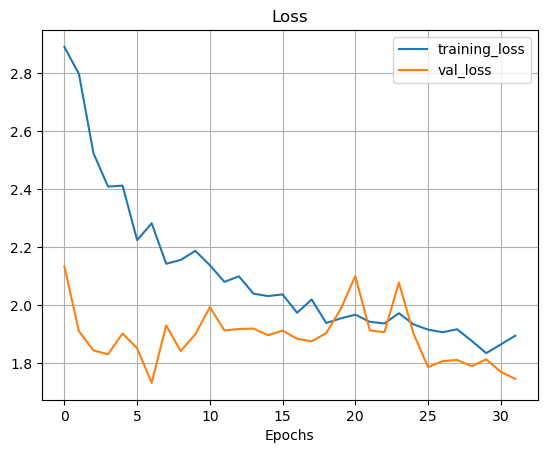

In [99]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()
  plt.grid()


plot_loss_curves(history_LSTM)

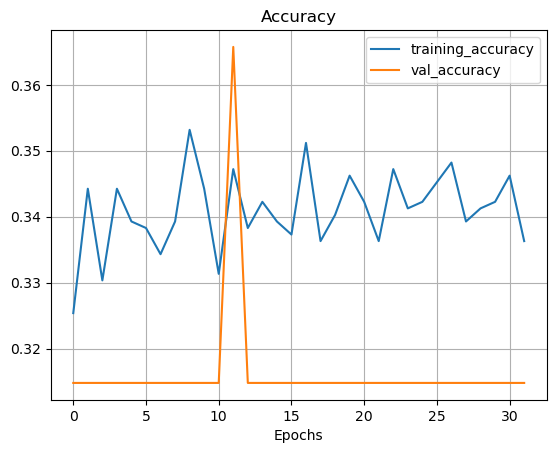

In [100]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))


  # Plot accuracy
  plt.figure()
  plt.grid()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

plot_loss_curves(history_LSTM)

In [94]:
print("Input x_test_lstm Data Shape:", x_test_lstm.shape)
print("Target y_test_lstm Data Shape:", y_test_lstm.shape)

Input x_test_lstm Data Shape: (217, 52, 1)
Target y_test_lstm Data Shape: (216, 3)


In [86]:
# reduce the Target Data
# Assuming reshaped input data has shape (216, 52, 1)
reshaped_x_test_lstm_data = x_test_lstm

# Assuming target data has shape (217, 3)
target_test_lstm_data = y_test_lstm

# Make sure target data matches the number of samples in the input data
if target_test_lstm_data.shape[0] > reshaped_x_test_lstm_data.shape[0]:
    target_test_lstm_data = target_test_lstm_data[:reshaped_x_test_lstm_data.shape[0], :]

print("Reshaped Input Data Shape:", reshaped_x_test_lstm_data.shape)
print("Target Data Shape:", target_test_lstm_data.shape)

Reshaped Input Data Shape: (216, 52, 1)
Target Data Shape: (216, 3)


In [96]:
# Assuming reshaped_input_data and target_data are your existing arrays
reshaped_x_test_lstm_data = reshaped_x_test_lstm_data[:-1, :, :]
target_test_lstm_data = target_test_lstm_data[:, :]

print("New Reshaped Input Data Shape:", reshaped_x_test_lstm_data.shape)
print("New Target Data Shape:", target_test_lstm_data.shape)

New Reshaped Input Data Shape: (216, 52, 1)
New Target Data Shape: (216, 3)


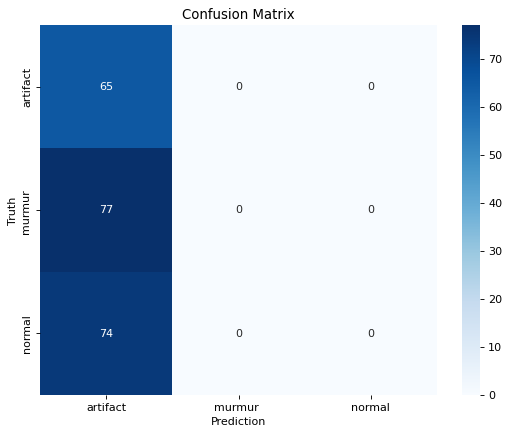

In [103]:
x_test_lstm = x_test_lstm
y_test_lstm = y_test_lstm

classes = ["artifact" ,"murmur ", "normal"]

preds = lstm_model.predict(x_test_lstm)
classpreds = [ np.argmax(t) for t in preds ]
y_testclass = [np.argmax(t) for t in y_test_lstm]
cm = confusion_matrix(y_testclass, classpreds)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [104]:
print(classification_report(y_testclass, classpreds, target_names=classes))

              precision    recall  f1-score   support

    artifact       0.30      1.00      0.46        65
     murmur        0.00      0.00      0.00        77
      normal       0.00      0.00      0.00        74

    accuracy                           0.30       216
   macro avg       0.10      0.33      0.15       216
weighted avg       0.09      0.30      0.14       216



C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [181]:
# def heart_prediction (file_path, duration=10, sr=22050):
#     classes=["MS","MR","normal"]
#     input_length=sr*duration
    
#     X, sr = librosa.load(file_path, sr=sr, duration=duration) 
#     dur = librosa.get_duration(y=X, sr=sr)
    
#     # pad audio file same duration
#     if (round(dur) < duration):
#         X = librosa.util.fix_length(X, input_length)
        
#     mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sr, n_mfcc=52, n_fft=512,hop_length=2048).T,axis=0)
#     feature = np.array(mfccs).reshape([-1,1])
    
#     preds=lstm_model.predict(mfccs.reshape(1,52,1))
#     preds=classes [np.argmax(preds)]
#     confidence = np.amax(preds)
#     return preds, confidence 

## Gru Model

In [105]:
x_train_gru = x_train
x_val_gru = x_val
x_test_gru =x_test

y_train_gru = y_train
y_val_gru = y_val
y_test_gru = y_test

In [106]:
print("Input x_train_Gru Data Shape:", x_train_gru.shape)
print("Target y_train_Gru Data Shape:", y_train_gru.shape)
print("-------------------------------------------")
print("Input x_val_Gru Data Shape:", x_val_gru.shape)
print("Target y_train_Gru Data Shape:", y_val_gru.shape)
print("-------------------------------------------")
print("Input x_test_Gru Data Shape:", x_test_gru.shape)
print("Target y_test_Gru Data Shape:", y_test_gru.shape)

Input x_train_Gru Data Shape: (1008, 52, 1)
Target y_train_Gru Data Shape: (1008, 3)
-------------------------------------------
Input x_val_Gru Data Shape: (216, 52, 1)
Target y_train_Gru Data Shape: (216, 3)
-------------------------------------------
Input x_test_Gru Data Shape: (216, 52, 1)
Target y_test_Gru Data Shape: (216, 3)


In [107]:
# Model Architecture

gru_model = Sequential()

gru_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
gru_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
gru_model.add(BatchNormalization())

gru_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
gru_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
gru_model.add(BatchNormalization())

gru_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
gru_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

gru_model.add(GRU(256, return_sequences=True))
gru_model.add(GRU(128))
gru_model.add(BatchNormalization())

gru_model.add(Dense(64, activation='relu'))
gru_model.add(Dropout(0.5))

gru_model.add(Dense(32, activation='relu'))
gru_model.add(Dropout(0.5))

gru_model.add(Dense(3, activation='softmax'))

gru_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 52, 2048)          12288     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 26, 2048)          0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 26, 2048)          8192      
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 26, 1024)          10486784  
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 13, 1024)          0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 13, 1024)          4096      
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 13, 512)          

In [108]:
# Compile the GRU model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.0001)
gru_model.compile(optimizer=optimiser,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Define callbacks
cb = [
    EarlyStopping(
        patience=20,
        monitor='val_accuracy',  # Monitor validation accuracy
        mode='max',  # Maximize the monitored metric
        restore_best_weights=True  # Restore the model's best weights when stopping early
    ),
    ModelCheckpoint(
        "working/Heart_GRU_CNN_1.h5",  # Save the best model to this file
        save_best_only=True  # Save only the best model checkpoint
    )
]

In [110]:
# training the model use GRU with epochs 250
history_gru = gru_model.fit(
    x_train_gru, y_train_gru,  # Replace with your GRU training data
    validation_data=(x_val_gru, y_val_gru),  # Replace with your validation data
    batch_size=8,
    epochs=250,
    class_weight=class_weight,
    callbacks=cb
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1008 samples, validate on 216 samples
Epoch 1/250
1008/1008 [==============================] - 1s 1ms/sample - loss: 1.7700 - accuracy: 0.3442 - val_loss: 4.4531 - val_accuracy: 0.3009
Epoch 2/250
1008/1008 [==============================] - 1s 945us/sample - loss: 1.7755 - accuracy: 0.3442 - val_loss: 7.1281 - val_accuracy: 0.3009
Epoch 3/250
1008/1008 [==============================] - 1s 1ms/sample - loss: 1.7686 - accuracy: 0.3442 - val_loss: 4.2656 - val_accuracy: 0.3009
Epoch 4/250
1008/1008 [==============================] - 1s 952us/sample - loss: 1.7677 - accuracy: 0.3442 - val_loss: 4.3870 - val_accuracy: 0.3009
Epoch 5/250
1008/1008 [==============================] - 1s 944us/sample - loss: 1.7768 - accuracy: 0.3442 - val_loss: 4.6607 - val_accuracy: 0.3009
Epoch 6/250
1008/1008 [==============================] - 1s 950us/sample - loss: 1.7669 - accuracy: 0.3442 - val_loss: 6.8302 - val_accuracy: 0.3009
Epoch 7/250
1

In [111]:
# training the model use GRU with epochs 150

history_gru1 = gru_model.fit(
    x_train_gru, y_train_gru,  # Replace with your GRU training data
    validation_data=(x_val_gru, y_val_gru),  # Replace with your validation data
    batch_size=8,
    epochs=150,
    class_weight=class_weight,
    callbacks=cb
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1008 samples, validate on 216 samples
Epoch 1/150
1008/1008 [==============================] - 1s 1ms/sample - loss: 1.7741 - accuracy: 0.3442 - val_loss: 1.7479 - val_accuracy: 0.3009
Epoch 2/150
1008/1008 [==============================] - 1s 1ms/sample - loss: 1.7711 - accuracy: 0.3442 - val_loss: 1.7439 - val_accuracy: 0.3009
Epoch 3/150
1008/1008 [==============================] - 1s 1ms/sample - loss: 1.7600 - accuracy: 0.3442 - val_loss: 1.7320 - val_accuracy: 0.3009
Epoch 4/150
1008/1008 [==============================] - 1s 957us/sample - loss: 1.7913 - accuracy: 0.3442 - val_loss: 1.7351 - val_accuracy: 0.3009
Epoch 5/150
1008/1008 [==============================] - 1s 989us/sample - loss: 1.7833 - accuracy: 0.3442 - val_loss: 1.7337 - val_accuracy: 0.3009
Epoch 6/150
1008/1008 [==============================] - 1s 1ms/sample - loss: 1.7755 - accuracy: 0.3442 - val_loss: 1.7267 - val_accuracy: 0.3009
Epoch 7/150
1008/

In [115]:
loss, accuracy = gru_model.evaluate(x_val_gru, y_test_gru)
print(f"Validation loss: {loss: f}")
print(f"Validation accuracy: {accuracy:f}")

# loss function value on the evaluation Data(validation data): 1.564836
# accuracy of the model on the evaluation data: 0.300926 ~ 30%

216/216 [==============================] - 0s 111us/sample - loss: 1.5827 - accuracy: 0.3148
Validation loss:  1.582737
Validation accuracy: 0.314815


In [113]:
accuracy = accuracy_score(y_val_gru, y_test_gru)
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.4398


In [116]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Calculate mean squared error and mean absolute error
mse = mean_squared_error(y_val_gru, y_test_gru)
mae = mean_absolute_error(y_val_gru, y_test_gru)
print(f"Mean Squared Error: {mse:f}")
print(f"Mean Absolute Error: {mae:f}")

Mean Squared Error: 0.373457
Mean Absolute Error: 0.373457


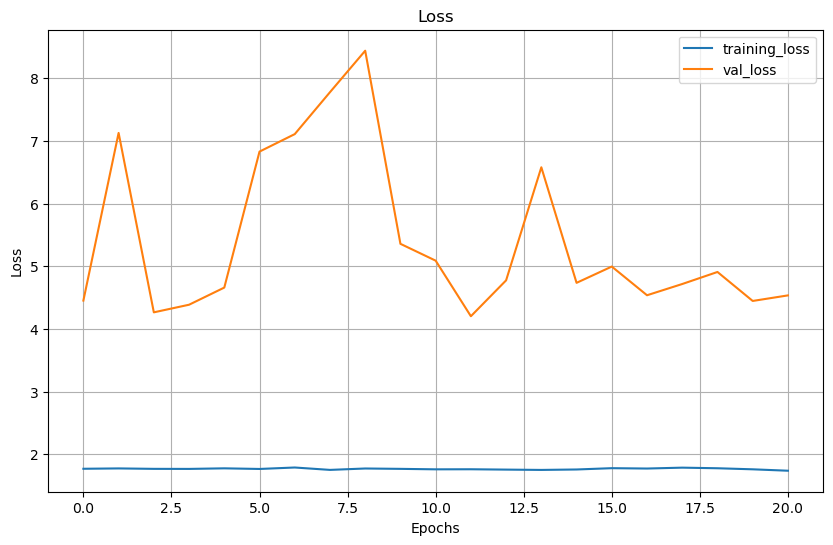

In [117]:
def plot_loss_curves(history):
    """
    Plots separate loss curves for training and validation metrics.
    Args:
        history: TensorFlow model History object
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming 'history' contains the training history of the GRU model
plot_loss_curves(history_gru)

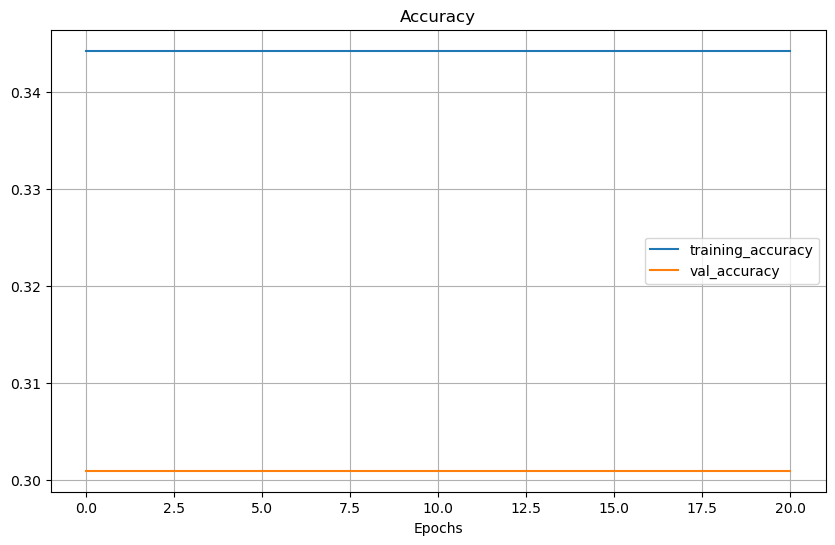

In [118]:
def plot_loss_curves(history):
    """
    Plots separate loss curves for training and validation metrics.
    Args:
        history: TensorFlow model History object
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))
 
    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_ Saccuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

# Assuming 'history_gru' contains the training history of the GRU model
plot_loss_curves(history_gru)

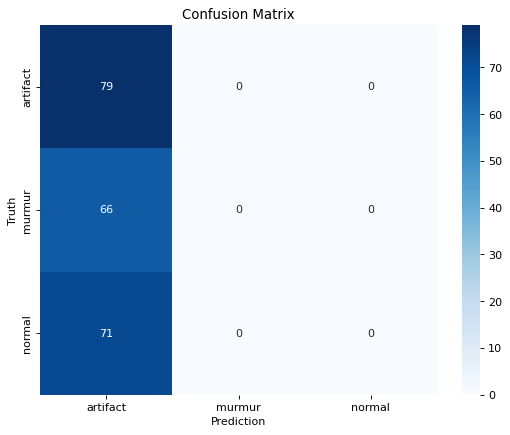

In [111]:

classes_gru = ["artifact", "murmur", "normal"]

preds = gru_model.predict(x_test_gru)
classpreds_gru = [np.argmax(t) for t in preds]
y_testclass_gru = [np.argmax(t) for t in y_test_gru]
cm = confusion_matrix(y_testclass_gru, classpreds_gru)

plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='Blues', annot=True, fmt='d', xticklabels=classes_gru, yticklabels=classes_gru)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [112]:
print(classification_report(y_testclass_gru, classpreds_gru, target_names=classes_gru))

              precision    recall  f1-score   support

    artifact       0.37      1.00      0.54        79
      murmur       0.00      0.00      0.00        66
      normal       0.00      0.00      0.00        71

    accuracy                           0.37       216
   macro avg       0.12      0.33      0.18       216
weighted avg       0.13      0.37      0.20       216



C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Bi-LSTM

In [113]:
x_train_bi_lstm = x_train
x_val_bi_lstm = reshaped_input_data
x_test_bi_lstm = reshaped_x_test_lstm_data

y_train_bi_lstm = y_train
y_val_bi_lstm = target_data
y_test_bi_lstm = target_test_lstm_data

In [114]:
print("Input x_train_bi_lstm Data Shape:", x_train_bi_lstm.shape)
print("Target y_train_bi_lstm Data Shape:", y_train_bi_lstm.shape)
print("-------------------------------------------")
print("Input x_val_bi_lstm Data Shape:", x_val_bi_lstm.shape)
print("Target y_train_bi_lstm Data Shape:", y_val_bi_lstm.shape)
print("-------------------------------------------")
print("Input x_test_bi_lstm Data Shape:", x_test_bi_lstm.shape)
print("Target y_test_bi_lstm Data Shape:", y_test_bi_lstm.shape)

Input x_train_bi_lstm Data Shape: (1007, 52, 1)
Target y_train_bi_lstm Data Shape: (1007, 3)
-------------------------------------------
Input x_val_bi_lstm Data Shape: (216, 52, 1)
Target y_train_bi_lstm Data Shape: (216, 3)
-------------------------------------------
Input x_test_bi_lstm Data Shape: (216, 52, 1)
Target y_test_bi_lstm Data Shape: (216, 3)


In [115]:
print("Input x_train_bi_lstm Data Shape:", x_train.shape)
print("Target y_train_bi_lstm Data Shape:", y_train.shape)
print("-------------------------------------------")
print("Input x_val_bi_lstm Data Shape:", x_val.shape)
print("Target y_train_bi_lstm Data Shape:", y_val.shape)
print("-------------------------------------------")
print("Input x_test_bi_lstm Data Shape:", x_test.shape)
print("Target y_test_bi_lstm Data Shape:", y_test.shape)

Input x_train_bi_lstm Data Shape: (1007, 52, 1)
Target y_train_bi_lstm Data Shape: (1007, 3)
-------------------------------------------
Input x_val_bi_lstm Data Shape: (216, 52, 1)
Target y_train_bi_lstm Data Shape: (216, 3)
-------------------------------------------
Input x_test_bi_lstm Data Shape: (217, 52, 1)
Target y_test_bi_lstm Data Shape: (217, 3)


In [116]:
# Model Architecture

# Create a Sequential model
bi_lstm_model = Sequential()

# Add Conv1D layers
bi_lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
bi_lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
bi_lstm_model.add(BatchNormalization())

bi_lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
bi_lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
bi_lstm_model.add(BatchNormalization())

bi_lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
bi_lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

# Add Bidirectional LSTM layers
bi_lstm_model.add(Bidirectional(LSTM(256, return_sequences=True)))
bi_lstm_model.add(Bidirectional(LSTM(128)))
bi_lstm_model.add(BatchNormalization())

# Add Dense layers with dropout
bi_lstm_model.add(Dense(64, activation='relu'))
bi_lstm_model.add(Dropout(0.5))

bi_lstm_model.add(Dense(32, activation='relu'))
bi_lstm_model.add(Dropout(0.5))

bi_lstm_model.add(Dense(3, activation='softmax'))

bi_lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_6 (Conv1D)            (None, 52, 2048)          12288     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 26, 2048)          0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 26, 2048)          8192      
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 26, 1024)          10486784  
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 13, 1024)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 13, 1024)          4096      
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 13, 512)          

In [117]:
# Compile the Bi-LSTM model
optimizer = Adam(learning_rate=0.0001)
bi_lstm_model.compile(optimizer=optimizer,
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(
        patience=20,
        monitor='val_accuracy',  # Monitor validation accuracy
        mode='max',  # Maximize the monitored metric
        restore_best_weights=True  # Restore the model's best weights when stopping early
    ),
    ModelCheckpoint(
        "working/Heart_Bi_LSTM_CNN_1.h5",  # Save the best model to this file
        save_best_only=True  # Save only the best model checkpoint
    )
]

In [118]:
# Training the Bi-LSTM model
history_bi_lstm = bi_lstm_model.fit(
    x_train_gru, y_train_gru,  # Replace with your Bi-LSTM training data
    validation_data=(x_val, y_val),  # Replace with your validation data
    batch_size=8,
    epochs=250,
    class_weight=class_weight,
    #callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1007 samples, validate on 216 samples
Epoch 1/250
1007/1007 [==============================] - 6s 6ms/sample - loss: 2.6862 - accuracy: 0.3347 - val_loss: 2.5674 - val_accuracy: 0.3704
Epoch 2/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 2.7550 - accuracy: 0.3376 - val_loss: 2.3232 - val_accuracy: 0.3611
Epoch 3/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 2.5947 - accuracy: 0.2880 - val_loss: 1.8203 - val_accuracy: 0.3657
Epoch 4/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 2.5012 - accuracy: 0.3337 - val_loss: 1.9587 - val_accuracy: 0.3380
Epoch 5/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 2.4972 - accuracy: 0.3257 - val_loss: 2.0456 - val_accuracy: 0.3241
Epoch 6/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 2.3035 - accuracy: 0.3178 - val_loss: 2.0508 - val_accuracy: 0.3287
Epoch 7/250
1007/1007

Epoch 55/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8018 - accuracy: 0.3357 - val_loss: 1.7627 - val_accuracy: 0.3657
Epoch 56/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8365 - accuracy: 0.3337 - val_loss: 1.7535 - val_accuracy: 0.3657
Epoch 57/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8513 - accuracy: 0.3297 - val_loss: 1.7428 - val_accuracy: 0.3657
Epoch 58/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8064 - accuracy: 0.3357 - val_loss: 1.7717 - val_accuracy: 0.3657
Epoch 59/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8490 - accuracy: 0.3337 - val_loss: 1.7246 - val_accuracy: 0.3657
Epoch 60/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8044 - accuracy: 0.3327 - val_loss: 1.7230 - val_accuracy: 0.3657
Epoch 61/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8258 - accuracy: 0.3317 - val_

1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7596 - accuracy: 0.3337 - val_loss: 2.0733 - val_accuracy: 0.3657
Epoch 166/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7561 - accuracy: 0.3337 - val_loss: 2.1061 - val_accuracy: 0.3657
Epoch 167/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7481 - accuracy: 0.3337 - val_loss: 1.9450 - val_accuracy: 0.3657
Epoch 168/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7638 - accuracy: 0.3337 - val_loss: 1.7210 - val_accuracy: 0.3657
Epoch 169/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7734 - accuracy: 0.3337 - val_loss: 1.8566 - val_accuracy: 0.3657
Epoch 170/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7643 - accuracy: 0.3337 - val_loss: 1.7408 - val_accuracy: 0.3657
Epoch 171/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7540 - accuracy: 0.3337 - val_loss: 1

1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7518 - accuracy: 0.3337 - val_loss: 1.7216 - val_accuracy: 0.3657
Epoch 221/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7400 - accuracy: 0.3337 - val_loss: 1.6938 - val_accuracy: 0.3657
Epoch 222/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7519 - accuracy: 0.3337 - val_loss: 1.7098 - val_accuracy: 0.3657
Epoch 223/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7669 - accuracy: 0.3327 - val_loss: 1.7375 - val_accuracy: 0.3657
Epoch 224/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7411 - accuracy: 0.3337 - val_loss: 1.7257 - val_accuracy: 0.3657
Epoch 225/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7486 - accuracy: 0.3337 - val_loss: 1.7215 - val_accuracy: 0.3657
Epoch 226/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7449 - accuracy: 0.3337 - val_loss: 1

In [119]:
# Training the Bi-LSTM model
history_bi_lstm1 = bi_lstm_model.fit(
    x_train_gru, y_train_gru,  # Replace with your Bi-LSTM training data
    validation_data=(x_val, y_val),  # Replace with your validation data
    batch_size=8,
    epochs=150,
    class_weight=class_weight,
    #callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1007 samples, validate on 216 samples
Epoch 1/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7402 - accuracy: 0.3337 - val_loss: 1.7784 - val_accuracy: 0.3657
Epoch 2/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7437 - accuracy: 0.3337 - val_loss: 1.8054 - val_accuracy: 0.3657
Epoch 3/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7381 - accuracy: 0.3337 - val_loss: 1.7214 - val_accuracy: 0.3657
Epoch 4/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7422 - accuracy: 0.3337 - val_loss: 1.7281 - val_accuracy: 0.3657
Epoch 5/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7441 - accuracy: 0.3337 - val_loss: 1.7382 - val_accuracy: 0.3657
Epoch 6/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7388 - accuracy: 0.3337 - val_loss: 1.7345 - val_accuracy: 0.3657
Epoch 7/150
1007/1007

Epoch 55/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7420 - accuracy: 0.3337 - val_loss: 1.7060 - val_accuracy: 0.3657
Epoch 56/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7370 - accuracy: 0.3337 - val_loss: 1.7217 - val_accuracy: 0.3657
Epoch 57/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7307 - accuracy: 0.3337 - val_loss: 1.7122 - val_accuracy: 0.3657
Epoch 58/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7351 - accuracy: 0.3337 - val_loss: 1.7029 - val_accuracy: 0.3657
Epoch 59/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7355 - accuracy: 0.3337 - val_loss: 1.6944 - val_accuracy: 0.3657
Epoch 60/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7340 - accuracy: 0.3337 - val_loss: 1.7059 - val_accuracy: 0.3657
Epoch 61/150
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.7337 - accuracy: 0.3337 - val_

In [120]:
loss, accuracy = bi_lstm_model.evaluate(x_val, y_val)
print(f"Validation loss: {loss: f} \n Validation accuracy: {accuracy:f}")

# loss function value on the evaluation Data(validation data): 1.466591 
# accuracy of the model on the evaluation data: 0.365741 ~ 30%

216/216 [==============================] - 1s 4ms/sample - loss: 1.4666 - accuracy: 0.3657
Validation loss:  1.466591 
 Validation accuracy: 0.365741


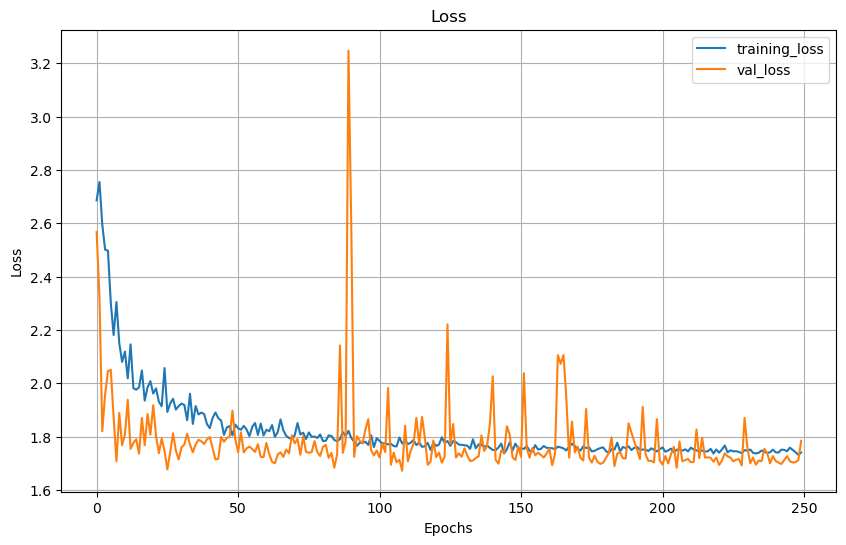

In [121]:
def plot_loss_curves(history):
    """
    Plots separate loss curves for training and validation metrics.
    Args:
        history: TensorFlow model History object
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming 'history_bi_lstm' contains the training history of the Bi-LSTM model
plot_loss_curves(history_bi_lstm)

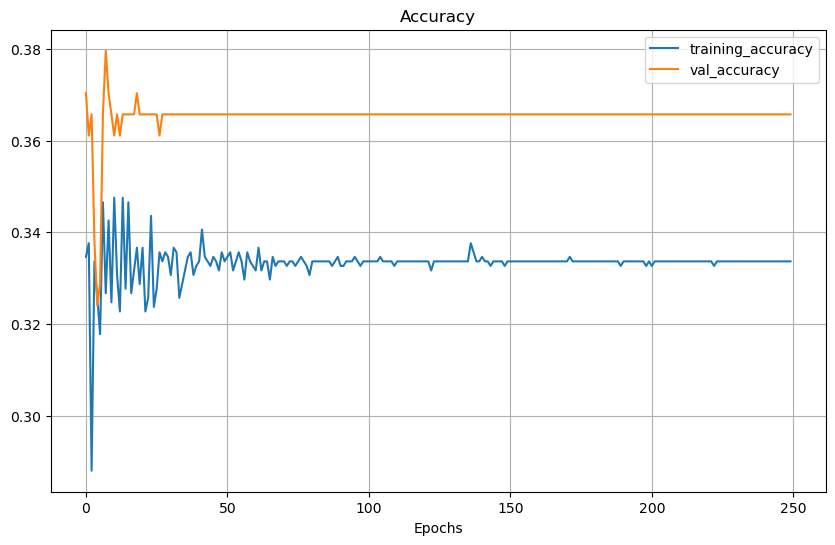

In [122]:
def plot_loss_curves(history):
    """
    Plots separate loss curves for training and validation metrics.
    Args:
        history: TensorFlow model History object
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

# Assuming 'history_bi_lstm' contains the training history of the Bi-LSTM model
plot_loss_curves(history_bi_lstm)

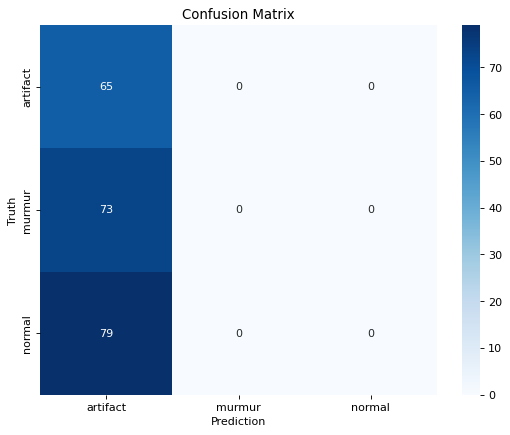

In [125]:
classes_bi_lstm = ["artifact", "murmur", "normal"]

# Get predictions from the Bi-LSTM model
preds_bi_lstm = bi_lstm_model.predict(x_test)
classpreds_bi_lstm = [np.argmax(t) for t in preds_bi_lstm]
y_testclass_bi_lstm = [np.argmax(t) for t in y_test]
cm_lstm = confusion_matrix(y_testclass_bi_lstm, classpreds_bi_lstm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm_lstm, cmap='Blues', annot=True, fmt='d', xticklabels=classes_bi_lstm, yticklabels=classes_bi_lstm)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [126]:
print(classification_report(y_testclass_bi_lstm, classpreds_bi_lstm, target_names=classes_bi_lstm))

              precision    recall  f1-score   support

    artifact       0.30      1.00      0.46        65
      murmur       0.00      0.00      0.00        73
      normal       0.00      0.00      0.00        79

    accuracy                           0.30       217
   macro avg       0.10      0.33      0.15       217
weighted avg       0.09      0.30      0.14       217



C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## CNN-LSTM

In [128]:
x_train_cnn_lstm = x_train
x_val_cnn_lstm = x_val
x_test_cnn_lstm = x_test

y_train_cnn_lstm = y_train
y_val_cnn_lstm = y_val
y_test_cnn_lstm = y_test

In [129]:
print("Input x_train_CNN_LSTM Data Shape:", x_train_cnn_lstm.shape)
print("Target y_train_CNN_LSTM Data Shape:", y_train_cnn_lstm.shape)
print("-------------------------------------------")
print("Input x_val_CNN_LSTM Data Shape:", x_val_cnn_lstm.shape)
print("Target y_train_CNN_LSTM Data Shape:", y_val_cnn_lstm.shape)
print("-------------------------------------------")
print("Input x_test_CNN_LSTM Data Shape:", x_test_cnn_lstm.shape)
print("Target y_test_CNN_LSTM Data Shape:", y_test_cnn_lstm.shape)

Input x_train_CNN_LSTM Data Shape: (1007, 52, 1)
Target y_train_CNN_LSTM Data Shape: (1007, 3)
-------------------------------------------
Input x_val_CNN_LSTM Data Shape: (216, 52, 1)
Target y_train_CNN_LSTM Data Shape: (216, 3)
-------------------------------------------
Input x_test_CNN_LSTM Data Shape: (217, 52, 1)
Target y_test_CNN_LSTM Data Shape: (217, 3)


In [130]:
# Create a Sequential model
cnn_lstm_model = Sequential()

# Add Conv1D layers
cnn_lstm_model.add(Conv1D(2048, kernel_size=5, strides=1, padding='same', activation='relu', input_shape=(52, 1)))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
cnn_lstm_model.add(BatchNormalization())

cnn_lstm_model.add(Conv1D(1024, kernel_size=5, strides=1, padding='same', activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))
cnn_lstm_model.add(BatchNormalization())

cnn_lstm_model.add(Conv1D(512, kernel_size=5, strides=1, padding='same', activation='relu'))
cnn_lstm_model.add(MaxPooling1D(pool_size=2, strides=2, padding='same'))

# Add LSTM layers
cnn_lstm_model.add(LSTM(256, return_sequences=True))
cnn_lstm_model.add(LSTM(128))
cnn_lstm_model.add(BatchNormalization())

# Add Dense layers with dropout
cnn_lstm_model.add(Dense(64, activation='relu'))
cnn_lstm_model.add(Dropout(0.5))

cnn_lstm_model.add(Dense(32, activation='relu'))
cnn_lstm_model.add(Dropout(0.5))

cnn_lstm_model.add(Dense(3, activation='softmax'))

cnn_lstm_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 52, 2048)          12288     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 26, 2048)          0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 26, 2048)          8192      
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 26, 1024)          10486784  
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 13, 1024)          0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 13, 1024)          4096      
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 13, 512)          

In [131]:
# Compile the CNN-LSTM model
optimizer = Adam(learning_rate=0.0001)
cnn_lstm_model.compile(optimizer=optimizer,
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

# Define callbacks
callbacks = [
    EarlyStopping(
        patience=20,
        monitor='val_accuracy',  # Monitor validation accuracy
        mode='max',  # Maximize the monitored metric
        restore_best_weights=True  # Restore the model's best weights when stopping early
    ),
    ModelCheckpoint(
        "working/Heart_CNN_LSTM_1.h5",  # Save the best model to this file
        save_best_only=True  # Save only the best model checkpoint
    )
]

In [132]:
history_cnn_lstm = cnn_lstm_model.fit(
    x_train_cnn_lstm, y_train_cnn_lstm,  # Replace with your CNN-LSTM training data
    validation_data=(x_val_cnn_lstm, y_val_cnn_lstm),  # Replace with your validation data
    batch_size=8,
    epochs=250,
    class_weight=class_weight,
    #callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1007 samples, validate on 216 samples
Epoch 1/250
1007/1007 [==============================] - 4s 4ms/sample - loss: 3.1911 - accuracy: 0.3257 - val_loss: 2.4520 - val_accuracy: 0.3657
Epoch 2/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 2.9332 - accuracy: 0.3158 - val_loss: 2.0414 - val_accuracy: 0.3657
Epoch 3/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 2.6428 - accuracy: 0.3217 - val_loss: 1.8358 - val_accuracy: 0.3657
Epoch 4/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 2.4441 - accuracy: 0.3386 - val_loss: 2.0387 - val_accuracy: 0.3657
Epoch 5/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 2.3285 - accuracy: 0.3386 - val_loss: 2.3002 - val_accuracy: 0.3657
Epoch 6/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 2.3562 - accuracy: 0.3406 - val_loss: 2.2700 - val_accuracy: 0.3657
Epoch 7/250
1007/1007

Epoch 55/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.8053 - accuracy: 0.3337 - val_loss: 1.7493 - val_accuracy: 0.3657
Epoch 56/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8237 - accuracy: 0.3357 - val_loss: 1.7239 - val_accuracy: 0.3657
Epoch 57/250
1007/1007 [==============================] - 2s 2ms/sample - loss: 1.8330 - accuracy: 0.3357 - val_loss: 1.7587 - val_accuracy: 0.3657
Epoch 58/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.8177 - accuracy: 0.3307 - val_loss: 1.7573 - val_accuracy: 0.3657
Epoch 59/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.8301 - accuracy: 0.3357 - val_loss: 1.7676 - val_accuracy: 0.3657
Epoch 60/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.8123 - accuracy: 0.3317 - val_loss: 1.7419 - val_accuracy: 0.3657
Epoch 61/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.8155 - accuracy: 0.3366 - val_

1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7657 - accuracy: 0.3337 - val_loss: 1.7262 - val_accuracy: 0.3657
Epoch 166/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7667 - accuracy: 0.3337 - val_loss: 1.7206 - val_accuracy: 0.3657
Epoch 167/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7514 - accuracy: 0.3337 - val_loss: 1.7097 - val_accuracy: 0.3657
Epoch 168/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7558 - accuracy: 0.3337 - val_loss: 1.7097 - val_accuracy: 0.3657
Epoch 169/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7432 - accuracy: 0.3337 - val_loss: 1.7079 - val_accuracy: 0.3657
Epoch 170/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7501 - accuracy: 0.3337 - val_loss: 1.7019 - val_accuracy: 0.3657
Epoch 171/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7457 - accuracy: 0.3337 - val_loss: 1

1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7500 - accuracy: 0.3337 - val_loss: 1.7238 - val_accuracy: 0.3657
Epoch 221/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7432 - accuracy: 0.3337 - val_loss: 1.7201 - val_accuracy: 0.3657
Epoch 222/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7485 - accuracy: 0.3337 - val_loss: 1.7253 - val_accuracy: 0.3657
Epoch 223/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7462 - accuracy: 0.3337 - val_loss: 1.7243 - val_accuracy: 0.3657
Epoch 224/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7434 - accuracy: 0.3337 - val_loss: 1.7188 - val_accuracy: 0.3657
Epoch 225/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7563 - accuracy: 0.3337 - val_loss: 1.7159 - val_accuracy: 0.3657
Epoch 226/250
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7409 - accuracy: 0.3337 - val_loss: 1

In [133]:
history_cnn_lstm1 = cnn_lstm_model.fit(
    x_train_cnn_lstm, y_train_cnn_lstm,  # Replace with your CNN-LSTM training data
    validation_data=(x_val_cnn_lstm, y_val_cnn_lstm),  # Replace with your validation data
    batch_size=8,
    epochs=150,
    class_weight=class_weight,
    #callbacks=callbacks
)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 1007 samples, validate on 216 samples
Epoch 1/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7376 - accuracy: 0.3337 - val_loss: 1.7136 - val_accuracy: 0.3657
Epoch 2/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7346 - accuracy: 0.3337 - val_loss: 1.7169 - val_accuracy: 0.3657
Epoch 3/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7468 - accuracy: 0.3337 - val_loss: 1.7194 - val_accuracy: 0.3657
Epoch 4/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7439 - accuracy: 0.3337 - val_loss: 1.7224 - val_accuracy: 0.3657
Epoch 5/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7478 - accuracy: 0.3337 - val_loss: 1.7235 - val_accuracy: 0.3657
Epoch 6/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7414 - accuracy: 0.3347 - val_loss: 1.7229 - val_accuracy: 0.3657
Epoch 7/150
1007/1007

Epoch 55/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7476 - accuracy: 0.3337 - val_loss: 1.7177 - val_accuracy: 0.3657
Epoch 56/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7411 - accuracy: 0.3337 - val_loss: 1.7161 - val_accuracy: 0.3657
Epoch 57/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7441 - accuracy: 0.3337 - val_loss: 1.7169 - val_accuracy: 0.3657
Epoch 58/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7345 - accuracy: 0.3337 - val_loss: 1.7164 - val_accuracy: 0.3657
Epoch 59/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7331 - accuracy: 0.3337 - val_loss: 1.7154 - val_accuracy: 0.3657
Epoch 60/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7387 - accuracy: 0.3337 - val_loss: 1.7157 - val_accuracy: 0.3657
Epoch 61/150
1007/1007 [==============================] - 1s 1ms/sample - loss: 1.7303 - accuracy: 0.3337 - val_

In [134]:
loss, accuracy = cnn_lstm_model.evaluate(x_val_cnn_lstm, y_val_cnn_lstm)
print(f"Validation loss: {loss: f} \n Validation accuracy: {accuracy:f}")

# loss function value on the evaluation Data(validation data): 1.425509   
# accuracy of the model on the evaluation data: 0.365741 ~ 30%

216/216 [==============================] - 1s 3ms/sample - loss: 1.4255 - accuracy: 0.3657
Validation loss:  1.425509 
 Validation accuracy: 0.365741


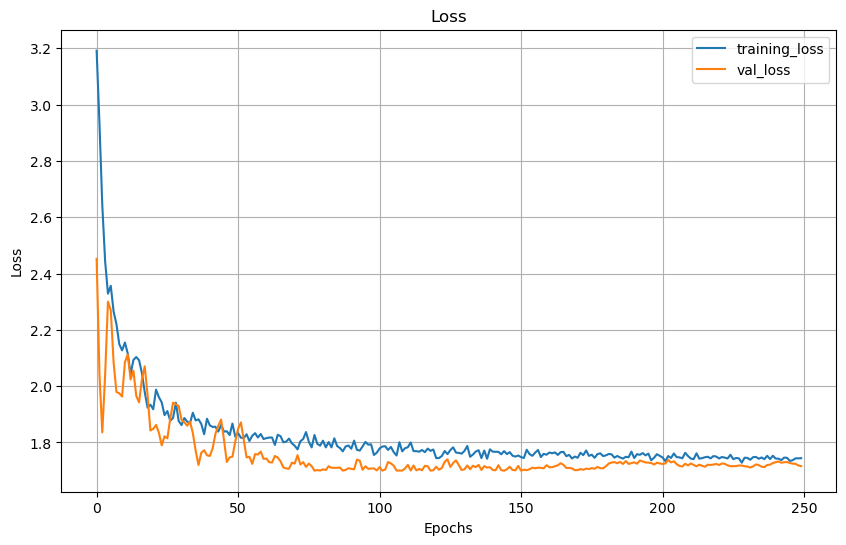

In [135]:
def plot_loss_curves(history):
    """
    Plots separate loss curves for training and validation metrics.
    Args:
        history: TensorFlow model History object
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, label='training_loss')
    plt.plot(epochs, val_loss, label='val_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()

# Assuming 'history_bi_lstm' contains the training history of the Bi-LSTM model
plot_loss_curves(history_cnn_lstm)

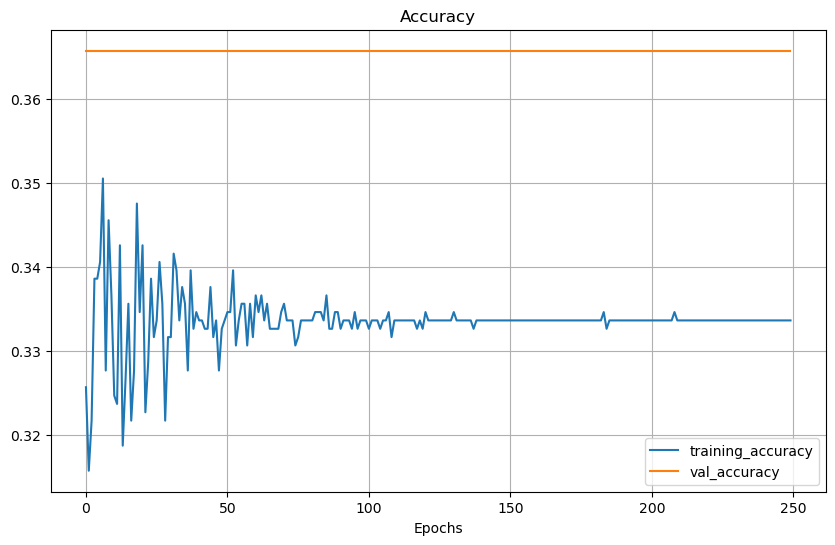

In [137]:
def plot_loss_curves(history):
    """
    Plots separate loss curves for training and validation metrics.
    Args:
        history: TensorFlow model History object
    """
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']

    epochs = range(len(history.history['loss']))

    # Plot accuracy
    plt.figure(figsize=(10, 6))
    plt.grid()
    plt.plot(epochs, accuracy, label='training_accuracy')
    plt.plot(epochs, val_accuracy, label='val_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

# Assuming 'history_cnn_lstm' contains the training history of the CNN-LSTM model
plot_loss_curves(history_cnn_lstm)

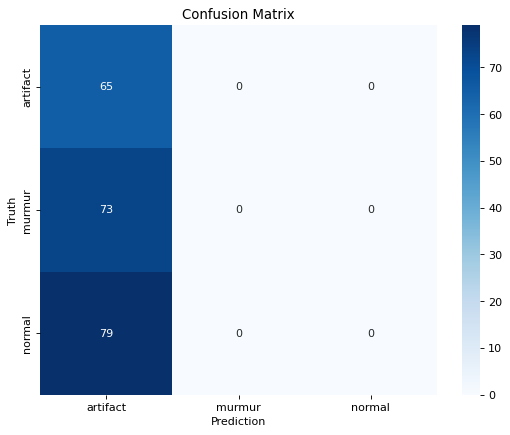

In [138]:
classes_cnn_lstm = ["artifact", "murmur", "normal"]

# Get predictions from the CNN-LSTM model
preds_cnn_lstm = cnn_lstm_model.predict(x_test_cnn_lstm)
classpreds_cnn_lstm = [np.argmax(t) for t in preds_cnn_lstm]
y_testclass_cnn_lstm = [np.argmax(t) for t in y_test_cnn_lstm]
cm_cnn_lstm = confusion_matrix(y_testclass_cnn_lstm, classpreds_cnn_lstm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm_cnn_lstm, cmap='Blues', annot=True, fmt='d', xticklabels=classes_cnn_lstm, yticklabels=classes_cnn_lstm)

plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show()

In [139]:
print(classification_report(y_testclass_cnn_lstm, classpreds_cnn_lstm, target_names=classes_cnn_lstm))

              precision    recall  f1-score   support

    artifact       0.30      1.00      0.46        65
      murmur       0.00      0.00      0.00        73
      normal       0.00      0.00      0.00        79

    accuracy                           0.30       217
   macro avg       0.10      0.33      0.15       217
weighted avg       0.09      0.30      0.14       217



C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Transformer

In [ ]:
def transformer_model(input_shape, num_classes, num_layers=4, d_model=512, num_heads=8, d_ff=2048, rate=0.1):
    inputs = Input(shape=input_shape)

    # Embedding layer
    embedding_layer = Embedding(input_dim=input_shape[0], output_dim=d_model)(inputs)
    positional_encoding = PositionalEncoding(input_shape[1], d_model)(embedding_layer)

    x = positional_encoding
    for _ in range(num_layers):
        # Multi-head self-attention
        x = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)([x, x])
        x = Dropout(rate)(x)
        x = LayerNormalization(epsilon=1e-6)(x)

        # Feed-forward neural network
        ff_network = tf.keras.Sequential([
            Dense(d_ff, activation='relu'),
            Dense(d_model)
        ])
        x = ff_network(x)
        x = Dropout(rate)(x)
        x = LayerNormalization(epsilon=1e-6)(x)

    # Global average pooling
    x = tf.reduce_mean(x, axis=1)

    # Classifier head
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Define model parameters
input_shape = (52, )
num_classes = 3
num_layers = 4
d_model = 512
num_heads = 8
d_ff = 2048
rate = 0.1

# Create the Transformer model
transformer_model = transformer_model(input_shape, num_classes, num_layers, d_model, num_heads, d_ff, rate)
transformer_model.summary()

In [162]:
from tensorflow.keras.layers import LayerNormalization, Embedding, PositionalEncoding

In [165]:
from tensorflow.keras.layers import MultiHeadAttention

ImportError: cannot import name 'MultiHeadAttention' from 'tensorflow.keras.layers' (C:\Users\Admin\anaconda3\envs\tensor-gpu\lib\site-packages\tensorflow_core\python\keras\api\_v2\keras\layers\__init__.py)